<h1 align="center"> Music Recommendation System  - Notebook</h1>

<h5 align="center"> Computational Tools for Data Science (02807)</h5>

<h5 align="center">Students: Adrian Valentin (s201390), Christoffer Wejendorp (s204090), Jákup Viljam Dam (s185095) & Jasmin Thari (s204155) </h5>


### Structure of this Notebook

This notebook is organized into six distinct sections as outlined below. Each section focuses on a specific aspect of the music recommendation system, from data preparation to the ensemble-based recommendation system.

1. **[Data Preparation](#1)**: Focuses on collecting and structuring the data files into a representative dataset for analysis.

2. **[Pre-processing & Feature Engineering](#2)**: Details the steps taken to clean and prepare the data for analysis, along with feature engineering processes to enhance the dataset.

3. **[Clustering](#3)**: Covers the use of clustering methods for music recommendation. Three approaches are demonstrated: K-means, K-means with PCA, and K-means with Autoencoders. The best-performing clustering model will then be used to recommend songs to users.

4. **[Collaborative Filtering](#4)**: Explores user-based collaborative filtering, which identifies similar users based on their preferences. This method leverages the idea that similar users are likely to have similar music tastes.

5. **[Apriori Algorithm](#5)**: Explores the use of the Apriori algorithm to discover association rules between songs, helping identify songs that are frequently listened to together.

6. **[Ensemble-Based Music Recommendation System](#6)**: Combines the strengths of the three recommendation methods; clustering, collaborative filtering, and the Apriori algorithm, into an ensemble approach for a more accurate and diverse music recommendation system.

---

### Table of Contents
1. **[Data Preparation](#1)**
2. **[Pre-processing & Feature Engineering](#2)**
3. **[Clustering](#3)**
4. **[Collaborative Filtering](#4)**
5. **[Apriori Algorithm](#5)**
6. **[Ensemble-Based Music Recommendation System](#6)**

__________

### Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os
import time
import json
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
import numpy as np
import math

from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix, tril
from scipy.special import comb

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from visualization_functions import *

__________

<a id="1"></a>
# Section 1: Data Preparation

In this section, we process raw data from the **Million Song Dataset** to construct datasets suitable for our music recommendation system. The raw data includes:

1. **Song Metadata (HDF5 format)**: Contains details such as artist information, song duration, tempo, key, mode and more.
2. **Genre Information (CLS format)**: Categorizes songs into genres.
3. **User Listening Data (TXT format)**: Logs user interactions with songs, including user IDs and song IDs.
4. **Track-Song Mapping (TXT format)**: Provides a mapping between `track_id` and `song_id` to unify data sources.

The **`MakeData` class** orchestrates the preprocessing steps, which include:

- Extracting metadata and analysis data from HDF5 files.
- Creating a mapping between songs and tracks.
- Merging metadata, analysis, and genre information into a unified dataset.
- Filtering songs played by users for targeted recommendations.

The processed datasets are saved in the `processed` folder within the `data` directory and include:

1. **`all_songs.csv`**: A comprehensive dataset with song metadata and features.
2. **`played_songs.csv`**: A filtered dataset containing only songs that have been played by users. This data is used in our recommendation system.

The raw files are assumed to be located in a `data/raw` folder, in the root directory.

## 1.1: Make Data

In [79]:
class MakeData:
    """
    A class to create and pre-process the datasets from HDF5 and other raw data files from Million Song Dataset (MSD).
    """

    def __init__(
        self,
        h5_file_path: str,
        unique_tracks_path: str,
        genre_path: str,
        user_data_path: str,
        output_dir: str = "data",
    ):
        """
        Initializes the DataSetMaker with the necessary file paths.

        Parameters:
            h5_file_path (str): Path to the HDF5 file.
            unique_tracks_path (str): Path to the unique_tracks.txt file.
            genres_paths (list): List of paths to genres files (e.g., ['cd1', 'cd2', 'cd2c']).
            user_data_path (str): Path to the user_data.txt file.
            output_dir (str): Directory where output CSV files will be saved.
        """
        self.h5_file_path = h5_file_path
        self.unique_tracks_path = unique_tracks_path
        self.genre_path = genre_path 
        self.user_data_path = user_data_path
        self.output_dir = output_dir

        # Ensure the output directory exists
        os.makedirs(self.output_dir, exist_ok=True)

        # Initialize dictionaries and DataFrames
        self.dfs = {}
        self.song_to_track_mapping = pd.DataFrame()
        self.merged_df = pd.DataFrame()

    def extract_dfs_from_h5(self):
        """
        Extracts datasets from the HDF5 file and stores them as pandas DataFrames in a dictionary.
        """
        def extract_df_from_h5(file, indent=0, datasets=None):
            if datasets is None:
                datasets = {}
            for key in file:
                item = file[key]
                print("  " * indent + f"- {key}: {type(item)}")

                if isinstance(item, h5py.Group):
                    # Recursively extract from groups
                    extract_df_from_h5(item, indent + 1, datasets)
                elif isinstance(item, h5py.Dataset):
                    # Extract dataset into DataFrame
                    columns = list(item.dtype.names)
                    df = pd.DataFrame(item[:], columns=columns)

                    # Decode byte columns to strings if necessary
                    for col in df.columns:
                        if df[col].dtype == 'O' and isinstance(df[col].iloc[0], bytes):
                            df[col] = df[col].apply(
                                lambda x: x.decode('utf-8') if isinstance(x, bytes) else x
                            )

                    # Store the DataFrame with the dataset's full path as the key
                    datasets[item.name] = df
            return datasets

        with h5py.File(self.h5_file_path, 'r') as h5_file:
            self.dfs = extract_df_from_h5(h5_file)
        print("Extraction from HDF5 completed.")

    def create_song_to_track_mapping(self):
        """
        Creates a mapping between song IDs and track IDs from the unique_tracks.txt file.
        """
        df_unique_tracks = pd.read_csv(
            self.unique_tracks_path,
            sep='<SEP>',
            header=None,
            engine='python',
            names=['track_id', 'song_id', 'artist', 'title']
        )
        self.song_to_track_mapping = df_unique_tracks[['song_id', 'track_id']].drop_duplicates(subset='song_id', keep='first')
        print("Song to track mapping created.")

    def merge_metadata_and_analysis(self):
        """
        Merges metadata and analysis DataFrames based on song_id and track_id.
        Also cleans the merged DataFrame by removing unnecessary columns.
        """
        # Load necessary DataFrames
        metadata_df = self.dfs.get('/metadata/songs')
        analysis_df = self.dfs.get('/analysis/songs')

        if metadata_df is None or analysis_df is None:
            raise ValueError("Required datasets '/metadata/songs' or '/analysis/songs' not found in HDF5 file.")

        # Drop duplicate song_ids
        metadata_df = metadata_df.drop_duplicates(subset='song_id', keep='first')

        # Merge with song_to_track_mapping
        merged_df = metadata_df.merge(self.song_to_track_mapping, on='song_id', how='inner')

        # Merge with analysis_df on track_id
        merged_df = merged_df.merge(analysis_df, on='track_id', how='inner')

        # Remove unnecessary columns
        columns_to_drop = [
            "artist_7digitalid",
            "artist_mbid",
            "artist_playmeid",
            "release_7digitalid",
            "track_7digitalid",
            "audio_md5",
        ]
        merged_df = merged_df.drop(columns=[col for col in columns_to_drop if col in merged_df.columns])

        # Remove columns with only one unique value
        merged_df = merged_df.loc[:, merged_df.nunique() > 1]

        self.merged_df = merged_df
        print("Metadata and analysis DataFrames merged and cleaned.")
    
    def process_genres(self):
        
        """
        Processes genre classification files and merges them into a single DataFrame.
        """        
        df_genre = pd.read_csv(
            self.genre_path,
            sep="\t",
            comment='#',
            header=None,
            names=["trackId", "majority_genre", "minority_genre"],
            engine='python'
        )
        
        # Remove minority_genre column and rename majority_genre to genre
        df_genre = df_genre.drop(columns=['minority_genre'])
        df_genre = df_genre.rename(columns={'majority_genre': 'genre'})
      
        # merge with the merged_df
        self.merged_df = self.merged_df.merge(df_genre, left_on='track_id', right_on='trackId', how='left')
        self.merged_df = self.merged_df.drop(columns=['trackId'])

    def save_merged_df(self):
        """
        Saves the merged DataFrame to a CSV file.
        """
        # Sort columns alphabetically
        self.merged_df = self.merged_df.reindex(sorted(self.merged_df.columns), axis=1)

        # Define the output path
        merged_csv_path = os.path.join(self.output_dir, "all_songs.csv")
        self.merged_df.to_csv(merged_csv_path, index=False)
        print(f"Merged DataFrame saved to {merged_csv_path}")

    def process_played_songs(self):
        """
        Load user data to find and save songs that have been played by users.
        """
        # Load user data
        df_user_data = pd.read_csv(
            self.user_data_path,
            sep='\t',
            header=None,
            names=['user_id', 'song_id', 'play_count']
        )
        print("User data loaded.")

        # Find unique song_ids that have been played
        unique_song_ids = df_user_data['song_id'].unique()
        print(f"Found {len(unique_song_ids)} unique song IDs in user data.")

        # Load all songs DataFrame
        all_songs_csv_path = os.path.join(self.output_dir, "all_songs.csv")
        df_all_songs = pd.read_csv(all_songs_csv_path)
        print("All songs DataFrame loaded.")

        # Merge to find played songs
        df_played_songs = df_all_songs.merge(
            pd.DataFrame(unique_song_ids, columns=['song_id']),
            on='song_id',
            how='inner'
        )
        print(f"Found {len(df_played_songs)} songs that have been played by users.")

        # Save played songs to CSV
        played_songs_csv_path = os.path.join(self.output_dir, "played_songs.csv")
        df_played_songs.to_csv(played_songs_csv_path, index=False)
        print(f"Played songs DataFrame saved to {played_songs_csv_path}")

    def preprocess_data(self):
        """
        Executes all processing steps in sequence.
        """
        print("Starting data extraction from HDF5...")
        self.extract_dfs_from_h5()

        print("Creating song to track mapping...")
        self.create_song_to_track_mapping()

        print("Merging metadata and analysis DataFrames...")
        self.merge_metadata_and_analysis()

        print("Processing genres...")
        self.process_genres()
        
        print("Saving merged DataFrame to CSV...")
        self.save_merged_df()

        print("Processing user data...")
        self.process_played_songs()

        print("All processing steps completed successfully.")

In [ ]:
def get_data():
    # Define file paths
    h5_file = 'data/raw/msd_summary_file.h5'
    unique_tracks = 'data/raw/unique_tracks.txt'
    genre_path = 'data/raw/msd_tagtraum_cd2c.cls'
    user_data = 'data/raw/user_data.txt'
    output_directory = 'data/processed'

    # Initialize the DataSetMaker
    dataset_maker = MakeData(
        h5_file_path=h5_file,
        unique_tracks_path=unique_tracks,
        genre_path=genre_path,
        user_data_path=user_data,
        output_dir=output_directory
    )

    # Run all processing steps
    dataset_maker.preprocess_data()

In [81]:
def extract_dfs_from_h5(h5_file_path):
    """
    Extracts datasets from the HDF5 file and stores them as pandas DataFrames in a dictionary.
    """
    def extract_df_from_h5(file, indent=0, datasets=None):
        if datasets is None:
            datasets = {}
        for key in file:
            item = file[key]
            print("  " * indent + f"- {key}: {type(item)}")

            if isinstance(item, h5py.Group):
                # Recursively extract from groups
                extract_df_from_h5(item, indent + 1, datasets)
            elif isinstance(item, h5py.Dataset):
                # Extract dataset into DataFrame
                columns = list(item.dtype.names)
                df = pd.DataFrame(item[:], columns=columns)

                # Decode byte columns to strings if necessary
                for col in df.columns:
                    if df[col].dtype == 'O' and isinstance(df[col].iloc[0], bytes):
                        df[col] = df[col].apply(
                            lambda x: x.decode('utf-8') if isinstance(x, bytes) else x
                        )

                # Store the DataFrame with the dataset's full path as the key
                datasets[item.name] = df
        return datasets

    with h5py.File(h5_file_path, 'r') as h5_file:
        dfs = extract_df_from_h5(h5_file)
    print("Extraction from HDF5 completed.")
    return dfs

In [17]:
# Run this line to get the data
get_data()

Starting data extraction from HDF5...
- analysis: <class 'h5py._hl.group.Group'>
  - songs: <class 'h5py._hl.dataset.Dataset'>
- metadata: <class 'h5py._hl.group.Group'>
  - songs: <class 'h5py._hl.dataset.Dataset'>
- musicbrainz: <class 'h5py._hl.group.Group'>
  - songs: <class 'h5py._hl.dataset.Dataset'>
Extraction from HDF5 completed.
Creating song to track mapping...
Song to track mapping created.
Merging metadata and analysis DataFrames...
Metadata and analysis DataFrames merged and cleaned.
Processing genres...
Saving merged DataFrame to CSV...
Merged DataFrame saved to data/all_songs.csv
Processing user data...
User data loaded.
Found 384546 unique song IDs in user data.
All songs DataFrame loaded.
Found 384546 songs that have been played by users.
Played songs DataFrame saved to data/played_songs.csv
All processing steps completed successfully.


## 1.2: Load Data

In [2]:
class LoadData:
    """
    A class to load and manage datasets related to songs and user interactions.
    """

    def load_csv_file(self, data_path: str):
        """
        Loads the data_path file .csv file into a pandas DataFrame.
        """
        if not os.path.exists(data_path):
            raise FileNotFoundError(f"{data_path} does not exist.")
        df = pd.read_csv(data_path)
        return df
    
    def load_txt_file(self, data_path: str):
        """
        Loads the data_path file .csv file into a pandas DataFrame.
        """
        df = pd.read_csv(
            data_path,
            sep='\t',
            header=None,
            names=['user_id', 'song_id', 'play_count'], 
            engine='python'
        )
        return df

data_loader = LoadData()

In [3]:
df_played_songs = data_loader.load_csv_file(data_path='data/processed/played_songs.csv')
df_user = data_loader.load_txt_file(data_path='data/raw/user_data.txt')

In [92]:
print("Played songs shape:", df_played_songs.shape)
print("User data shape:", df_user.shape)
print("Number of unique users:", df_user['user_id'].nunique())

Played songs shape: (384546, 24)
User data shape: (48373586, 3)
Number of unique users: 1019318


In [4]:
df_played_songs.head(3)

,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude,artist_name,duration,end_of_fade_in,genre,...,mode_confidence,release,song_hotttnesss,song_id,start_of_fade_out,tempo,time_signature,time_signature_confidence,title,track_id
0,0.649822,0.394032,ARYZTJS1187B98C555,NaN,NaN,NaN,Faster Pussy cat,252.05506,2.049,NaN,...,0.688,Monster Ballads X-Mas,0.542899,SOQMMHC12AB0180CB8,236.635,87.002,4,0.940,Silent Night,TRMMMYQ128F932D901
1,0.448501,0.372349,ARNWYLR1187B9B2F9C,NaN,NaN,NaN,Yerba Brava,145.05751,0.000,NaN,...,0.451,De Culo,NaN,SOBNYVR12A8C13558C,138.687,87.433,4,0.000,Si Vos Querés,TRMMMCH128F425532C
2,0.555014,0.352949,AR59BSJ1187FB4474F,NaN,NaN,NaN,3 Gars Su'l Sofa,68.96281,0.363,NaN,...,0.590,Des cobras des tarentules,NaN,SOYGNWH12AB018191E,68.963,62.294,4,0.425,L'antarctique,TRMMMNS128F93548E1


In [22]:
df_user.head(3)

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2


<a id="2"></a>
# 2. Pre-processing & Feature Engineering

In this section, we preprocess the dataset and engineer features to optimize it for clustering and recommendation tasks. The key steps include:

- **Handling Missing Values**: Dropping rows with missing values (`NaN`) for columns critical to clustering.
- **One-Hot Encoding**: Encoding the `genre` column into binary features for each genre.
- **Frequency Encoding**: Encoding categorical columns, such as `artist_name` and `release`, based on their frequency of occurrence in the dataset.
- **Hashing Encoding**: Encoding `artist_name` using a hashing technique for efficient representation.
- **GeoPy for Geolocation Data**: Filling in missing longitude and latitude values for artist location using GeoPy to retrieve location data based on available information.

After preprocessing, the cleaned and feature-engineered data is saved as a new CSV file for subsequent analysis.

Additionally, we preprocess the user data by filtering for users who have listened to at **least 20 songs**. This ensures sufficient data is available for making reliable recommendations and for masking data during prediction tasks.

## 2.1: Data Cleaning

In [7]:
def drop_missing_values(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Drops rows with missing values in specified columns.

    Parameters:
        df (pd.DataFrame): The dataframe to clean.
        columns (list): List of column names to check for missing values.

    Returns:
        pd.DataFrame: Cleaned dataframe with missing values dropped.
    """
    cleaned_df = df.dropna(subset=columns).reset_index(drop=True)
    return cleaned_df

In [23]:
# Drop missing values
required_columns = ['genre', 'song_hotttnesss', 'artist_familiarity', 'title', 'artist_location']
df_played_songs = drop_missing_values(df_played_songs, required_columns)

## 2.2: Feature Engineering

In [ ]:
class FeatureEngineer:
    """
    A class for engineering features such as artist frequency and hashed artist names.
    """
    
    def one_hot_encode(self, df: pd.DataFrame, column: str) -> pd.DataFrame:
        """
        One-hot encodes a column in the dataframe.

        Parameters:
            df (pd.DataFrame): The dataframe containing the column to encode.
            column (str): The column name to one-hot encode.

        Returns:
            pd.DataFrame: The dataframe with the one-hot encoded column.
        """
        one_hot_encoded = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, one_hot_encoded], axis=1)
        return df

    def calculate_frequency(self, df: pd.DataFrame, column: str) -> pd.Series:
        """
        Calculates the frequency of each category in the column in the dataset.

        Parameters:
            df (pd.DataFrame): The dataframe containing artist data.
            column (str): The column name to calculate frequency for.

        Returns:
            pd.Series: A series mapping the category to their frequencies.
        """
        freq = df[column].value_counts()
        return freq

    def hash_artist_features(self, df: pd.DataFrame, n_features, artist_column: str = 'artist_name') -> pd.DataFrame:
        """
        Applies feature hashing to the artist names.

        Parameters:
            df (pd.DataFrame): The dataframe containing artist data.
            artist_column (str): The column name for artist names.

        Returns:
            pd.DataFrame: A dataframe with hashed artist features.
        """
        hasher = FeatureHasher(n_features=n_features, input_type='dict', alternate_sign=False)
        feature_dicts = [{'artist_' + name: 1} for name in df[artist_column]]
        hashed_features = hasher.transform(feature_dicts)
        hashed_features_dense = hashed_features.toarray()
        hashed_df = pd.DataFrame(hashed_features_dense, 
                                  columns=[f'artist_hash_{i}' for i in range(n_features)])
        return hashed_df

In [ ]:
feature_engineer = FeatureEngineer()

# One-hot encode genres
df_played_songs = feature_engineer.one_hot_encode(df_played_songs, 'genre')

# Calculate artist frequency
artist_freq = feature_engineer.calculate_frequency(df_played_songs, 'artist_name')

# Hash artist features
hashed_df = feature_engineer.hash_artist_features(df_played_songs, n_features=50)

# Calculate release frequency
release_freq = feature_engineer.calculate_frequency(df_played_songs, 'release')

# Concatenate hashed features, artist_freq and release_freq with the songs dataframe
df_processed = pd.concat([df_played_songs, hashed_df], axis=1)
df_processed['artist_freq'] = df_processed['artist_name'].map(artist_freq)
df_processed['release_freq'] = df_processed['release'].map(release_freq)

In [ ]:
class GeocoderService:
    """
    A class to handle geocoding of artist locations to obtain latitude and longitude.
    """

    def __init__(self, user_agent: str = "music_recommender"):
        """
        Initializes the GeocoderService with a specified user agent.

        Parameters:
            user_agent (str): User agent string for the Nominatim geocoder.
        """
        self.geolocator = Nominatim(user_agent=user_agent)

    def get_lat_lon(self, location: str) -> list:
        """
        Retrieves the latitude and longitude for a given location.

        Parameters:
            location (str): The location string to geocode.

        Returns:
            list: A list containing latitude and longitude. [latitude, longitude]
        """
        try:
            loc = self.geolocator.geocode(location)
            if loc:
                return [loc.latitude, loc.longitude]
            else:
                return [np.nan, np.nan]
        except Exception as e:
            print(f"Error geocoding '{location}': {e}")
            return [np.nan, np.nan]
        finally:
            time.sleep(1)  

In [ ]:
geocoder = GeocoderService()

# Handle missing latitude and longitude of artist bu Geocode using locations
missing_condition = (df_processed['artist_latitude'].isna() | df_processed['artist_longitude'].isna())
missing_coordinates = df_processed.loc[missing_condition, 'artist_location'].unique()

location_coords = {}
for location in missing_coordinates:
    lat, lon = geocoder.get_lat_lon(location)
    if not (np.isnan(lat) or np.isnan(lon)):
        location_coords[location] = (lon, lat)  
    else:
        location_coords[location] = (np.nan, np.nan)  # Handle failed geocoding

def get_lat(location):
    return location_coords.get(location, (np.nan, np.nan))[1]

def get_lon(location):
    return location_coords.get(location, (np.nan, np.nan))[0]

# Apply the mapping to fill in missing latitude and longitude
df_processed.loc[missing_condition, 'artist_latitude'] = df_processed.loc[missing_condition, 'artist_location'].apply(get_lat)
df_processed.loc[missing_condition, 'artist_longitude'] = df_processed.loc[missing_condition, 'artist_location'].apply(get_lon)

# Drop rows with missing latitude and longitude which could not be filled
df_processed.dropna(subset=['artist_latitude', 'artist_longitude'], inplace=True)

In [24]:
df_played_songs_preprocessed = data_loader.load_csv_file(data_path='data/processed/played_songs_cleaned.csv')

In [25]:
print("Preprocessed played songs shape:", df_played_songs_preprocessed.shape)

Preprocessed played songs shape: (64539, 91)


In [27]:
df_played_songs_preprocessed.head(2)

,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude,artist_name,duration,end_of_fade_in,genre,...,artist_hash_42,artist_hash_43,artist_hash_44,artist_hash_45,artist_hash_46,artist_hash_47,artist_hash_48,artist_hash_49,artist_freq,release_freq
0,0.529819,0.410229,ARSB5591187B99A848,57.426350,"Vetlanda, Sweden",15.085180,Lena Philipsson,262.26893,0.194,Pop,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5
1,0.738996,0.563367,ARDT9VH1187B999C0B,33.687439,South Carolina,-80.436374,Emery,217.57342,0.514,Rock,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,4


## 2.3: Preprocess user data

In [ ]:
def filter_users_with_min_songs(df_user: pd.DataFrame, df_songs_subs: pd.DataFrame, min_songs: int) -> pd.DataFrame:
    """
    Filters users who have subscribed to at least a specified number of songs.

    Parameters:
        df_user (pd.DataFrame): User dataframe.
        df_songs_subs (pd.DataFrame): Subscribed songs dataframe.
        min_songs (int): Minimum number of songs a user must have subscribed to.

    Returns:
        pd.DataFrame: Filtered dataframe with users meeting the criteria.
    """
    merged_df = pd.merge(df_songs_subs[['song_id']], df_user, on='song_id', how='left')
    user_subs_filtered = merged_df[merged_df.groupby('user_id')['user_id'].transform('count') > min_songs]
    return user_subs_filtered

In [ ]:
# Filter users with at least 20 song subscriptions
df_user_preprocessed = filter_users_with_min_songs(df_user, df_played_songs_preprocessed, min_songs=20)
df_user_preprocessed.to_csv('data/processed/user_data_cleaned.csv', index=False)

In [96]:
df_user_preprocessed = data_loader.load_csv_file(data_path='data/processed/user_data_cleaned.csv')

In [10]:
print("Preprocessed user data shape:", df_user_preprocessed.shape)
print("Number of unique users:", df_user_preprocessed['user_id'].nunique())

Preprocessed user data shape: (7749050, 3)
Number of unique users: 183808


## 2.4: Split data 

- We will split the data into training and testing sets for evaluation purposes.
- First, we will split the users into 85% train users and 15% test users.
- Then, we will split the interactions for the test users into listened songs and masked songs, where for each user we will have 10 masked songs. 

In [ ]:
unique_users = df_user_preprocessed['user_id'].unique()
# Split users into training and testing sets using a 85-15 split
train_users, test_users = train_test_split(unique_users, test_size=0.15, random_state=42)

In [99]:
print("Train users shape:", train_users.shape)
print("Test users shape:", test_users.shape)

Train users shape: (156236,)
Test users shape: (27572,)


In [ ]:
def split_listened_and_masked(dataframe):
    """
    Splits the input dataframe into two separate dataframes: one containing the first 10 songs 
    (masked) for each user and the other containing the remaining songs (listened).

    Args:
        dataframe (pd.DataFrame): The input dataframe containing user listening data. 
                                  It must have a 'user_id' column to group by users.

    Returns:
        tuple: A tuple containing two pandas DataFrames:
            - listened (pd.DataFrame): DataFrame containing the remaining songs after the first 10 for each user.
            - masked (pd.DataFrame): DataFrame containing the first 10 songs for each user.
    """
    listened = []
    masked = []
    for user, group in dataframe.groupby('user_id'):
        group = group.sample(frac=1, random_state=42)  # Shuffle group
        masked.append(group.iloc[:10])  # First 10 songs as masked
        listened.append(group.iloc[10:])  # Remaining songs as listened

    return pd.concat(listened), pd.concat(masked)

In [106]:
# Split interactions for test users into listened and masked
df_interactions_test_users = df_user_preprocessed[df_user_preprocessed['user_id'].isin(test_users)]
listened_songs, masked_songs = split_listened_and_masked(df_interactions_test_users)

# 3. Clustering

In this section, we’ll cluster unique songs using their metadata to group similar songs together based on their features. This clustering will help us recommend songs to users by identifying the clusters that the user belongs most to based on the music they’ve already listened to.

To achieve this, we will explore two distinct clustering methodologies: 

1. **K-Means Clustering with PCA**: Principal Component Analysis (PCA) will be employed to reduce the dimensionality of the song features, capturing the most significant variations in the data while retaining the essential information for clustering. 

2. **K-Means Clustering with Autoencoder**: An autoencoder, a neural network designed for unsupervised feature extraction, will be used to compress the song metadata into a lower-dimensional latent space. The resulting latent representations will then serve as inputs for K-means clustering, leveraging the power of deep learning to extract complex patterns and relationships between songs.

Based on the best obtained clustering, we will use the identified clusters to recommend songs to users based on the songs they have listened to.

## 3.0: Define Functions

In [4]:
class StandardizeFeatures:
    """
    A class to prepare the processed data for modeling by splitting into training and testing sets and standardizing features.
    """
    def __init__(self, random_state: int = 42):
        """
        Initializes the DataModelPreparer with target column and split parameters.

        Parameters:
            random_state (int): Controls the shuffling applied to the data before applying the split.
        """
        self.random_state = random_state
        self.scaler = StandardScaler()

    def fit_transform_scaler(self, X_train: pd.DataFrame) -> pd.DataFrame:
        """
        Fits the scaler on the training data and transforms it.

        Parameters:
            X_train (pd.DataFrame): Training feature data.

        Returns:
            pd.DataFrame: Scaled training feature data.
        """
        scaled_train = self.scaler.fit_transform(X_train)
        scaled_train_df = pd.DataFrame(scaled_train, columns=X_train.columns, index=X_train.index)
        return scaled_train, scaled_train_df

    def transform_scaler(self, X_test: pd.DataFrame) -> pd.DataFrame:
        """
        Transforms the test data using the already fitted scaler.

        Parameters:
            X_test (pd.DataFrame): Testing feature data.

        Returns:
            pd.DataFrame: Scaled testing feature data.
        """
        scaled_test = self.scaler.transform(X_test)
        scaled_test_df = pd.DataFrame(scaled_test, columns=X_test.columns, index=X_test.index)
        return scaled_test, scaled_test_df

In [5]:
def determine_number_of_clusters_for_KMeans(data, max_clusters, random_state=42):
    """
    Evaluates KMeans clustering using Silhouette Score, and Davies-Bouldin Index for different number of clusters to determine the optimal number.

    Parameters:
        data (pd.DataFrame or np.ndarray): The input data for clustering.
        max_clusters (int): Maximum number of clusters to evaluate.
        random_state (int): Random state for reproducibility.

    Returns:
        dict: A dictionary containing:
              - 'silhouette_scores': Silhouette scores for each cluster size (2 to max_clusters).
              - 'davies_bouldin_indices': Davies-Bouldin indices for each cluster size (2 to max_clusters).
    """
    silhouette_scores = []
    davies_bouldin_indices = []

    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=random_state)
        kmeans.fit(data)
        
        if i > 1:  # Silhouette and Davies-Bouldin require at least 2 clusters
            cluster_labels = kmeans.labels_
            silhouette_scores.append(silhouette_score(data, cluster_labels))
            davies_bouldin_indices.append(davies_bouldin_score(data, cluster_labels))

    return {
        "silhouette_scores": silhouette_scores,
        "davies_bouldin_indices": davies_bouldin_indices
    }

In [6]:
# Initialize the StandardizeFeatures class
feature_scaler = StandardizeFeatures(random_state=42)

In [7]:
# Load data used for this section 
df_songs_cleaned = data_loader.load_csv_file(data_path='data/processed/played_songs_cleaned.csv')

In [8]:
# Select columns for clustering
cols_clustering = ['artist_familiarity', 'artist_hotttnesss','artist_latitude','artist_longitude','artist_freq',
                    'duration', 'loudness', 'tempo', 'time_signature', 'key', 'mode', 'song_hotttnesss', 'end_of_fade_in','start_of_fade_out','release_freq',
                    'genre_Blues','genre_Country', 'genre_Electronic', 'genre_Folk', 'genre_Jazz','genre_Latin', 'genre_Metal', 'genre_New Age', 
                    'genre_Pop','genre_Punk', 'genre_Rap', 'genre_Reggae', 'genre_RnB', 'genre_Rock','genre_World']
df_clustering = df_songs_cleaned[cols_clustering]

## 3.1: K-Means Clustering

In [9]:
clustering_scaled , df_clustering_scaled = feature_scaler.fit_transform_scaler(df_clustering)

In [10]:
max_clusters = 20
scores_kmeans_dict = determine_number_of_clusters_for_KMeans(clustering_scaled, max_clusters=max_clusters) 

/Users/jasmink.j.thari/Documents/anaconda3/envs/SGI/lib/python3.8/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


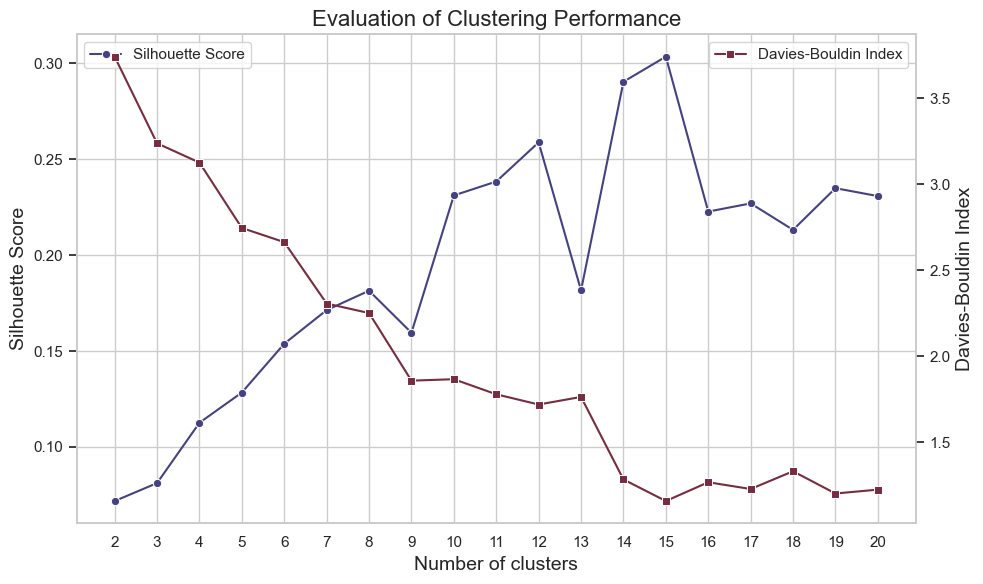

In [20]:
plot_cluster_evaluation(scores_kmeans_dict, max_clusters)

In [21]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_clustering['cluster'] = kmeans.fit_predict(df_clustering) + 1

/Users/jasmink.j.thari/.local/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


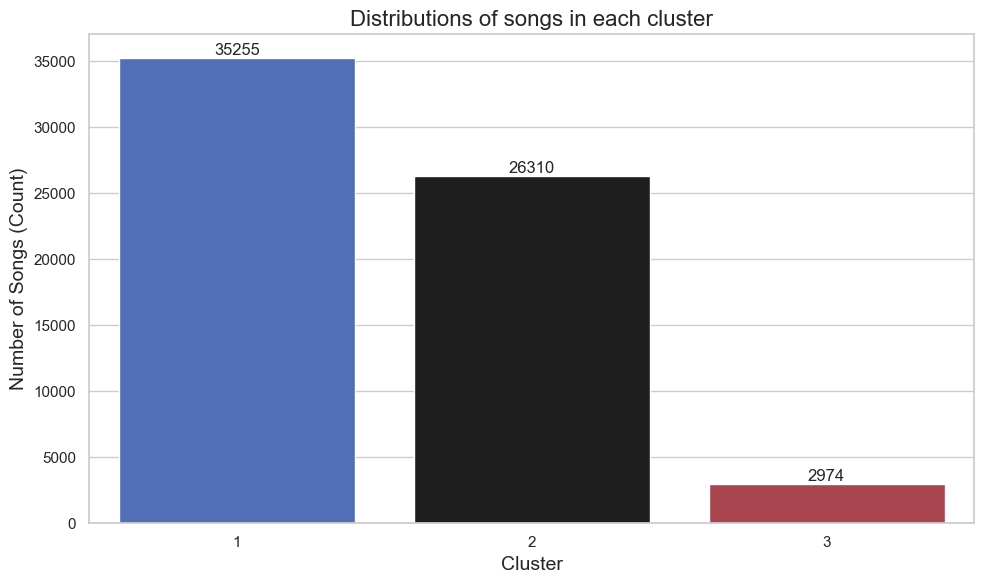

In [22]:
plot_cluster_distribution(df_clustering)

In [90]:
# Evaluate performance
silhouette_score_pca = silhouette_score(df_clustering.drop(columns=['cluster']), df_clustering['cluster'])
davies_bouldin_pca = davies_bouldin_score(df_clustering.drop(columns=['cluster']), df_clustering['cluster'])

print(f"Silhouette Score: {silhouette_score_pca:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_pca:.4f}")

Silhouette Score: 0.3254
Davies-Bouldin Index: 1.0003


- We see that the K-Means clustering on the raw data does not perform well. This is can be either due to the high dimensionality of the data, which makes it difficult for K-Means to identify meaningful clusters. To address this, we will apply PCA to reduce the dimensionality of the data before clustering.

## 3.2: K-Means Clustering with PCA

In [23]:
def run_pca(data: pd.DataFrame, n_components: int):
    """
    Trains a Principal Component Analysis (PCA) model on the given data and transforms the data into the specified number of principal components.

    Args:
        data (DataFrame): 
            The input data to be used for PCA. 
        n_components (int): 
            The number of principal components to retain during the transformation.

    Returns:
        tuple: A tuple containing:
            - PCA object: The trained PCA model containing information such as explained variance and components.
            - array-like: The transformed data in the reduced-dimensionality space.
    """
    pca = PCA(n_components=n_components, random_state=42)
    pca.fit(data)
    pca_transformed = pca.fit_transform(data)
    return pca, pca_transformed

In [24]:
# Standardize the features for clustering
clustering_scaled , df_clustering_scaled = feature_scaler.fit_transform_scaler(df_clustering)

In [26]:
# Run PCA to reduce the dimensionality of the data
pca, pca_transformed = run_pca(clustering_scaled, n_components=df_clustering_scaled.shape[1])

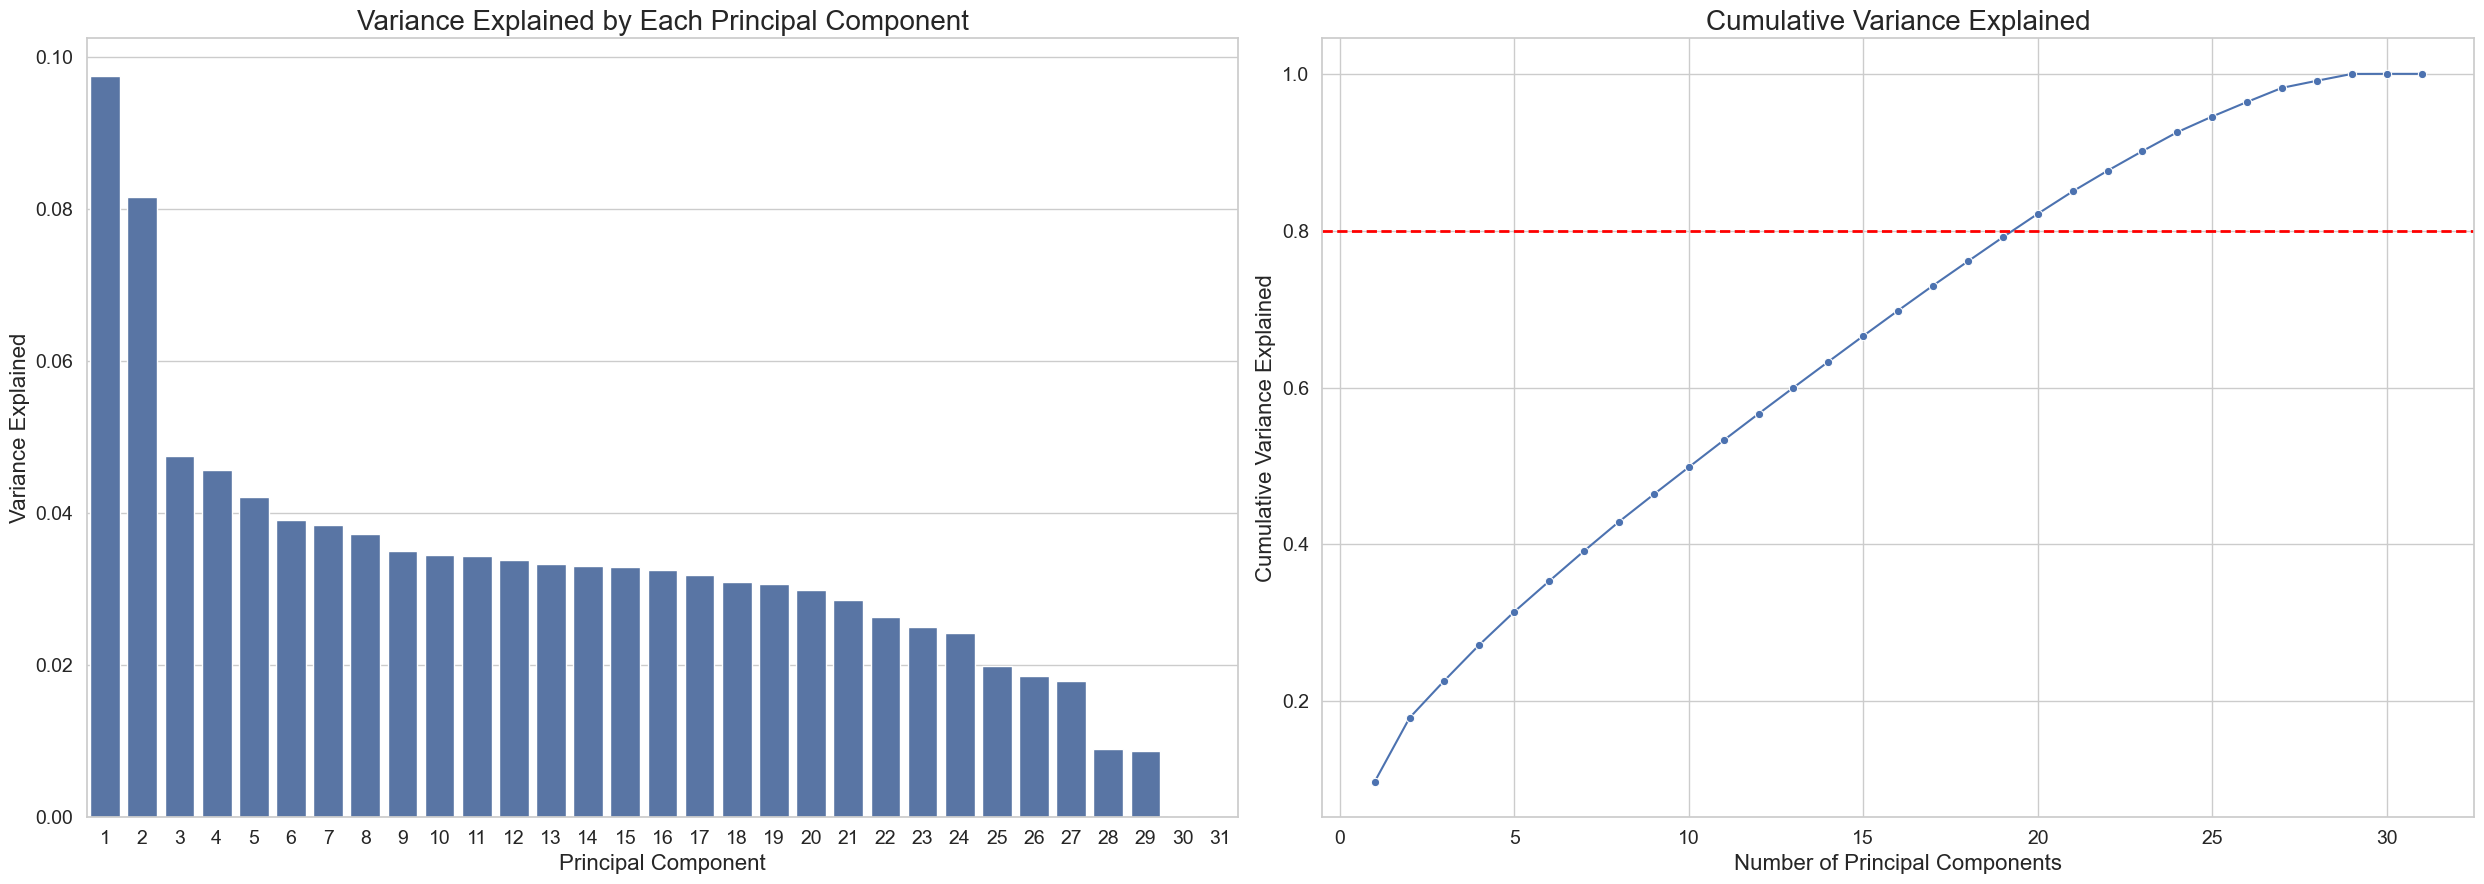

In [27]:
# Determine the optimal number of components for PCA
plot_pca_variance(pca)

- We need 19 PCs to explain 80% of the variance in the data.

In [28]:
num_pca = 19
pca, pca_transformed = run_pca(clustering_scaled, n_components=num_pca)
df_pca = pd.DataFrame(pca_transformed[:, :num_pca], columns=[f'PC{i+1}' for i in range(num_pca)])

In [29]:
max_clusters = 20
scores_pca_dict = determine_number_of_clusters_for_KMeans(df_pca, max_clusters=max_clusters) 

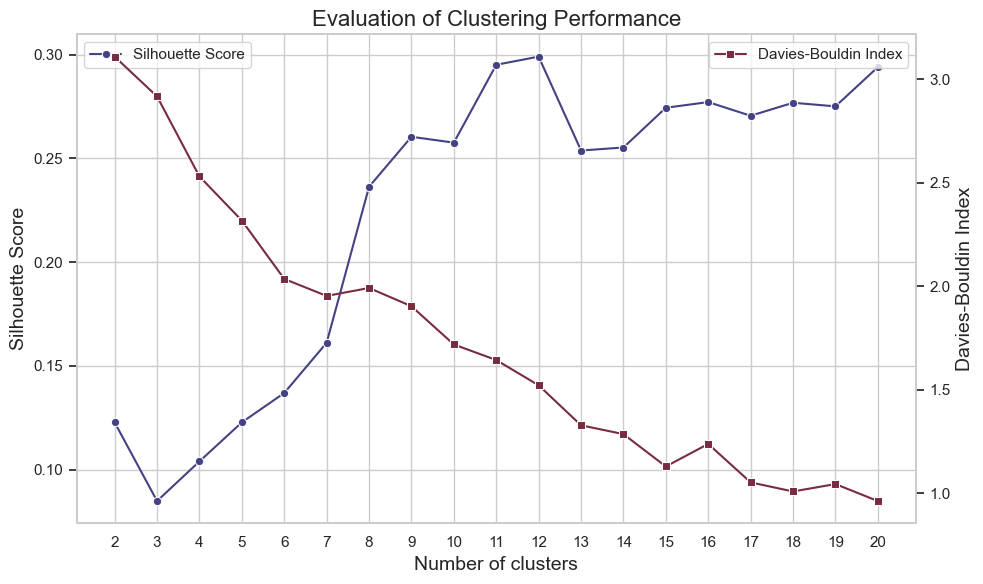

In [30]:
plot_cluster_evaluation(scores_pca_dict, max_clusters)

- Optimal number of clusters are determined using the Silhouette Score and Davies-Bouldin score, as the Elbow Method is not showing any clear elbow.
- The optimal number of clusters is then determined to be 17.

In [31]:
optimal_k = 12
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_pca['cluster'] = kmeans.fit_predict(df_pca) + 1

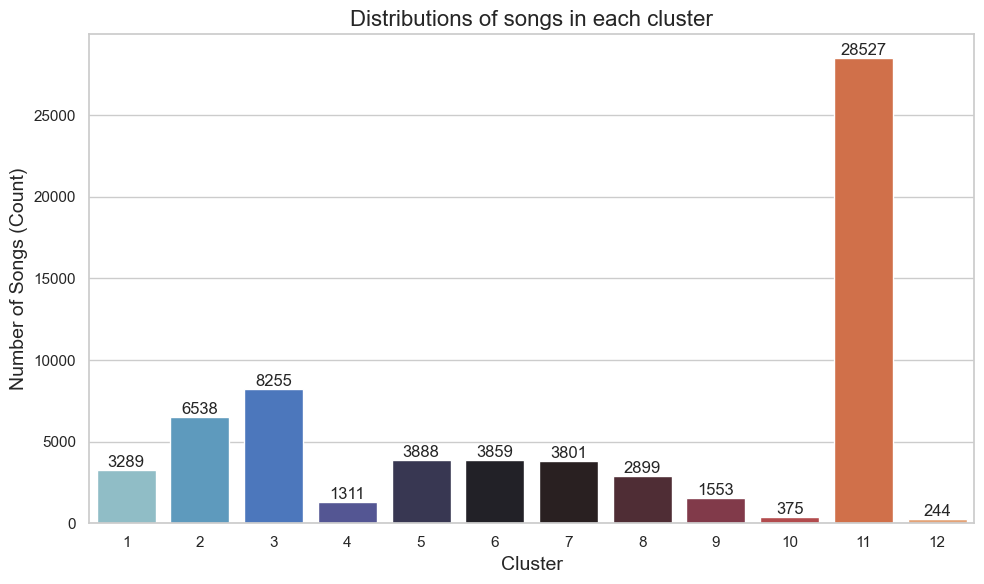

In [32]:
plot_cluster_distribution(df_pca)

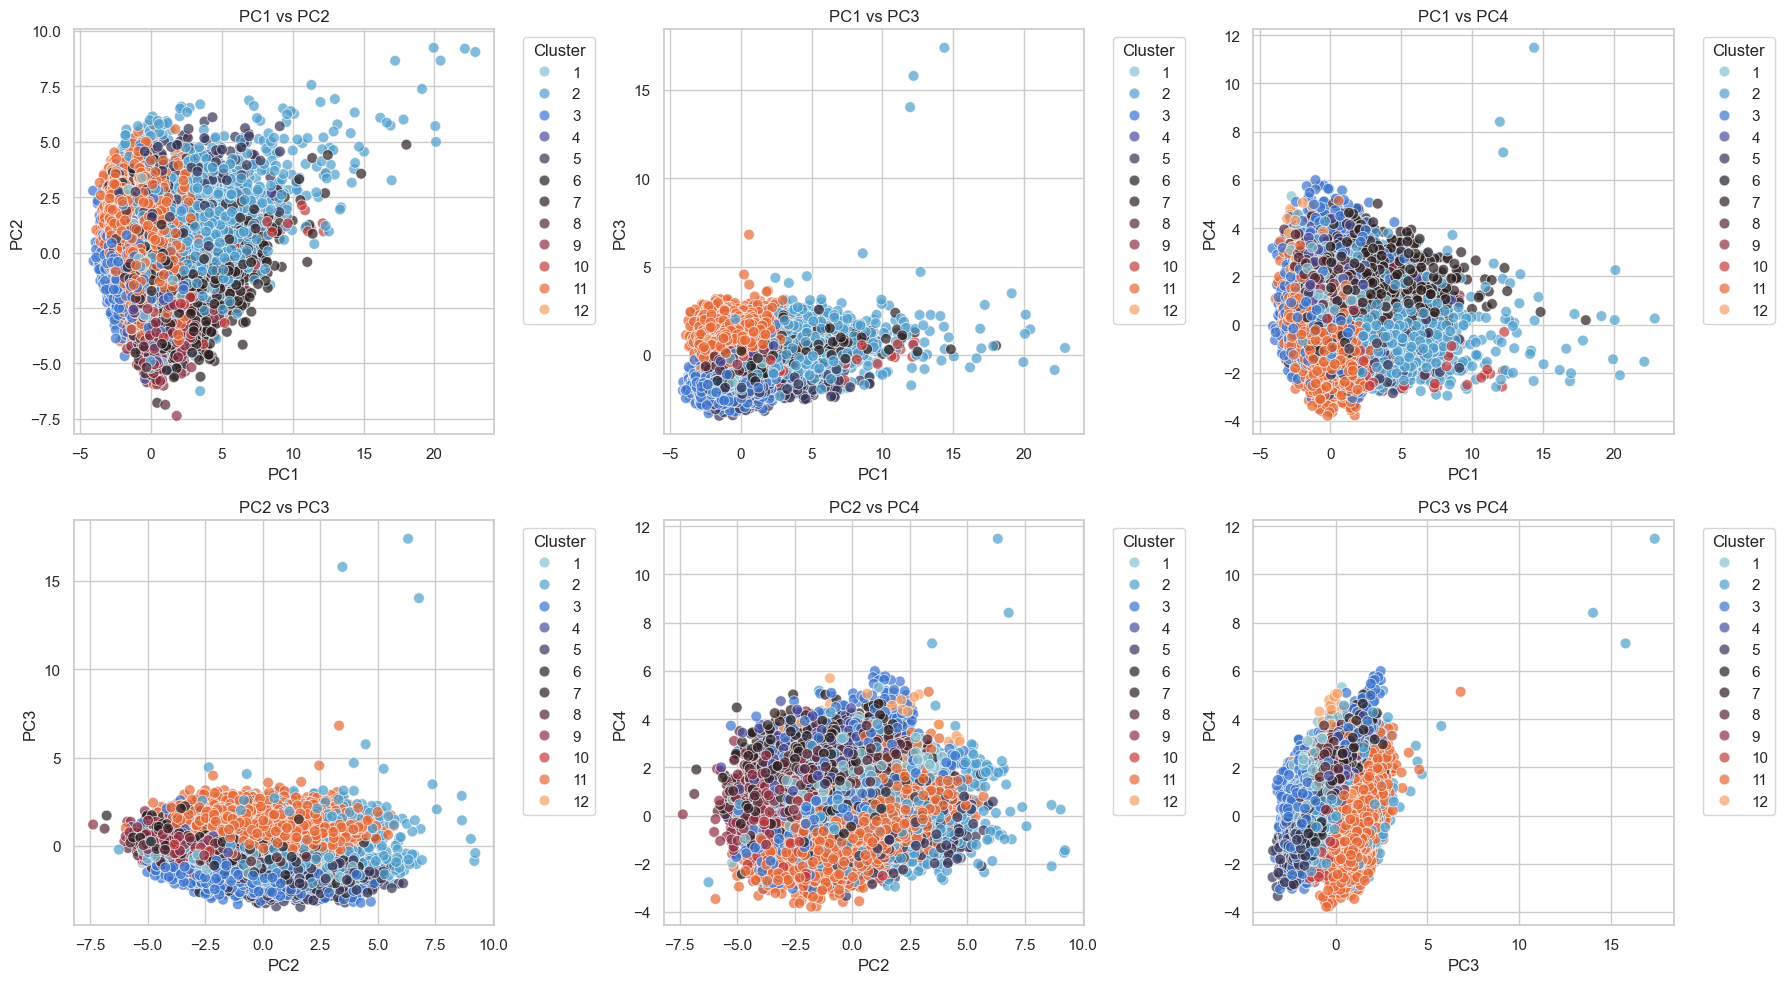

In [33]:
plot_pca_clustering(df_pca, optimal_k)

In [34]:
# Evaluate performance
silhouette_score_pca = silhouette_score(df_pca.drop(columns=['cluster']), df_pca['cluster'])
davies_bouldin_pca = davies_bouldin_score(df_pca.drop(columns=['cluster']), df_pca['cluster'])

print(f"Silhouette Score: {silhouette_score_pca:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_pca:.4f}")

Silhouette Score: 0.2990
Davies-Bouldin Index: 1.5205


- The K-means algorithm was applied on the 19 PCs and the optimal number of clusters to cluster the songs into 17 clusters.
- The obtained result was a Silhoutte Score on 0.29 and a Davies-Bouldin score of 1.1, which is not very good.
- When visualizing the clusters, we can see that the clusters are not very well separated and there is a lot of overlap between the clusters.
- Thus, we decide to try a more advanced and non-linear clustering method to see if we can get better results, where instead of using PCA, we use an autoencoder to reduce the dimensionality of the data.

## 3.3: K-Means Clustering with Autoencoder

In [35]:
def split_data_for_autoencoder(data: pd.DataFrame) -> tuple:
    """
    Splits the dataframe into training and testing sets.

    Parameters:
        df (pd.DataFrame): The dataframe to split.
        feature_columns (list, optional): List of columns to use as features. If None, all columns except target are used.

    Returns:
        tuple: X_train, X_test, y_train, y_test
    """        
    train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
    
    return train_data,val_data

In [36]:
class SongDataset(Dataset):
    def __init__(self, data):
        self.data = torch.from_numpy(data).float()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [94]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, input_dim),
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed


In [32]:
def train_model(model, train_loader, val_loader, num_epochs, learning_rate, weight_decay, model_name):
    """
    Train a PyTorch model with given parameters.

    Parameters:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader): DataLoader for the validation data.
        num_epochs (int): Number of epochs to train.
        learning_rate (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay for the optimizer.
        save_path (str, optional): Path to save the model checkpoints.

    Returns:
        dict: A dictionary containing training and validation losses per epoch.
    """
    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Define Loss and Optimizer
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Store losses for visualization
    loss_history = {'train': [], 'val': []}

    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        # Training phase
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as t:
            for batch in t:
                batch = batch.to(device)

                # Forward pass
                outputs = model(batch)
                loss = criterion(outputs, batch)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * batch.size(0)

                # Update tqdm progress bar
                t.set_postfix(loss=loss.item())

        train_loss /= len(train_loader.dataset)
        loss_history['train'].append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                outputs = model(batch)
                loss = criterion(outputs, batch)
                val_loss += loss.item() * batch.size(0)

        val_loss /= len(val_loader.dataset)
        loss_history['val'].append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save the model checkpoint if save_path is provided
    torch.save(model.state_dict(), f"models/{model_name}.pth")
    
    # save the history of loss
    history_path = f"models/history/{model_name}_history.json"
    with open(history_path, 'w') as json_file:
        json.dump(loss_history, json_file)
    print(f"Training history saved at: {history_path}")

    return loss_history, model


In [ ]:
train_data, val_data = split_data_for_autoencoder(df_clustering)
train_data_scaled,_ = feature_scaler.fit_transform_scaler(train_data)
val_data_scaled,_ = feature_scaler.transform_scaler(val_data)

In [ ]:
batch_size = 32
latent_dim = 10
epochs = 150
learning_rate = 1e-4
weight_decay = 1e-5
model_name = 'AE_Model1_hp2'

train_dataset = SongDataset(train_data_scaled)
val_dataset = SongDataset(val_data_scaled)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

input_dim = train_data.shape[1] 
model = Autoencoder(input_dim, latent_dim)
loss_history, model = train_model(model, train_loader, val_loader, epochs, learning_rate, weight_decay, model_name)

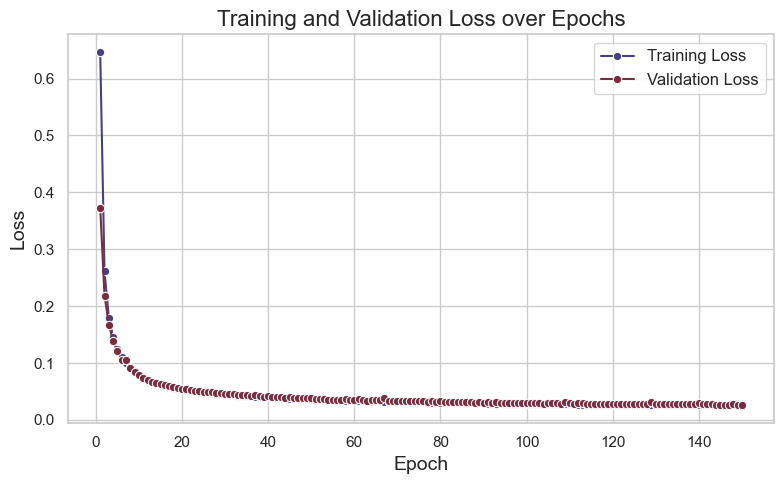

In [98]:
loss_history = json.load(open(f'models/AE_Model1_hp2_history.json'))
plot_training_loss(loss_history)

In [ ]:
# Extract latent representations of full data
model.eval()
df_clustering_scaled,_ =  feature_scaler.transform_scaler(df_clustering)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
df_clustering_scaled = torch.from_numpy(df_clustering_scaled).float().to(device)

with torch.no_grad():
    latent_representations = model.encoder(df_clustering_scaled).cpu().numpy()

df_latent_representations = pd.DataFrame(latent_representations, columns=[f'latent_{i+1}' for i in range(latent_dim)])

In [37]:
df_latent_representations = pd.read_csv('models/AE_Model1_hp2_latent_space.csv')

In [38]:
max_clusters = 20
scores_ae_dict = determine_number_of_clusters_for_KMeans(df_latent_representations, max_clusters=max_clusters) 

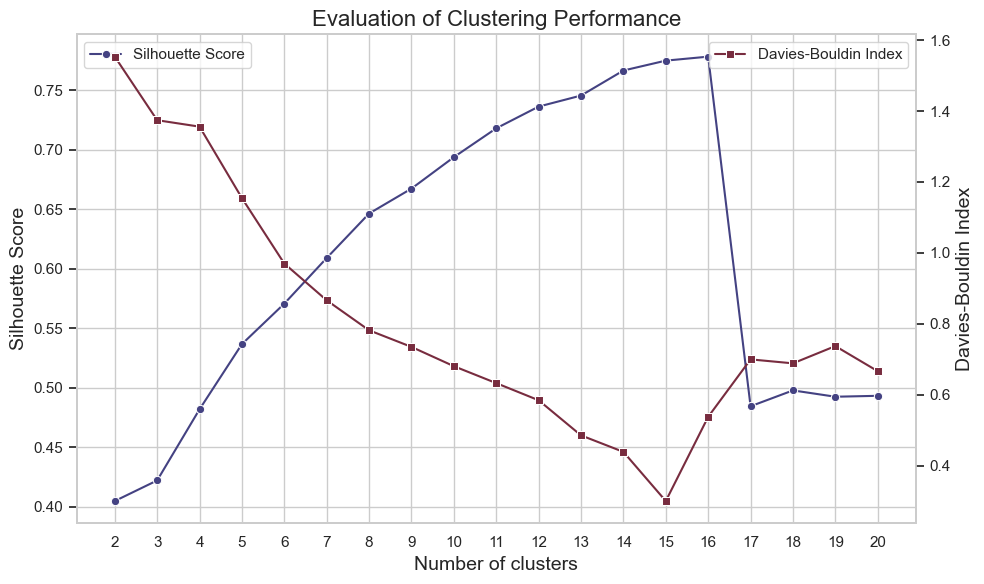

In [39]:
plot_cluster_evaluation(scores_ae_dict, max_clusters)

In [40]:
optimal_k = 15
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_latent_representations['cluster'] = kmeans.fit_predict(df_latent_representations) + 1

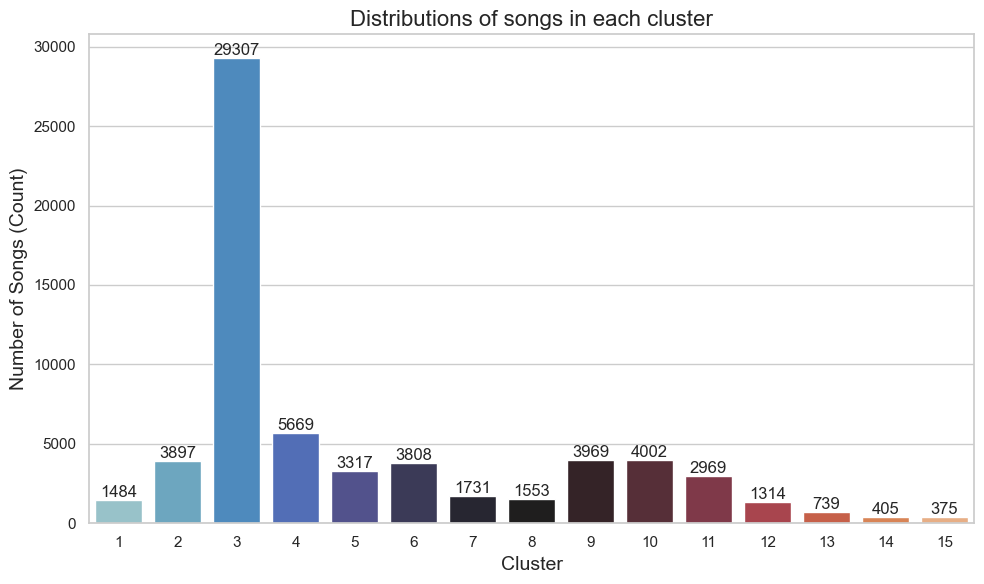

In [103]:
plot_cluster_distribution(df_latent_representations)

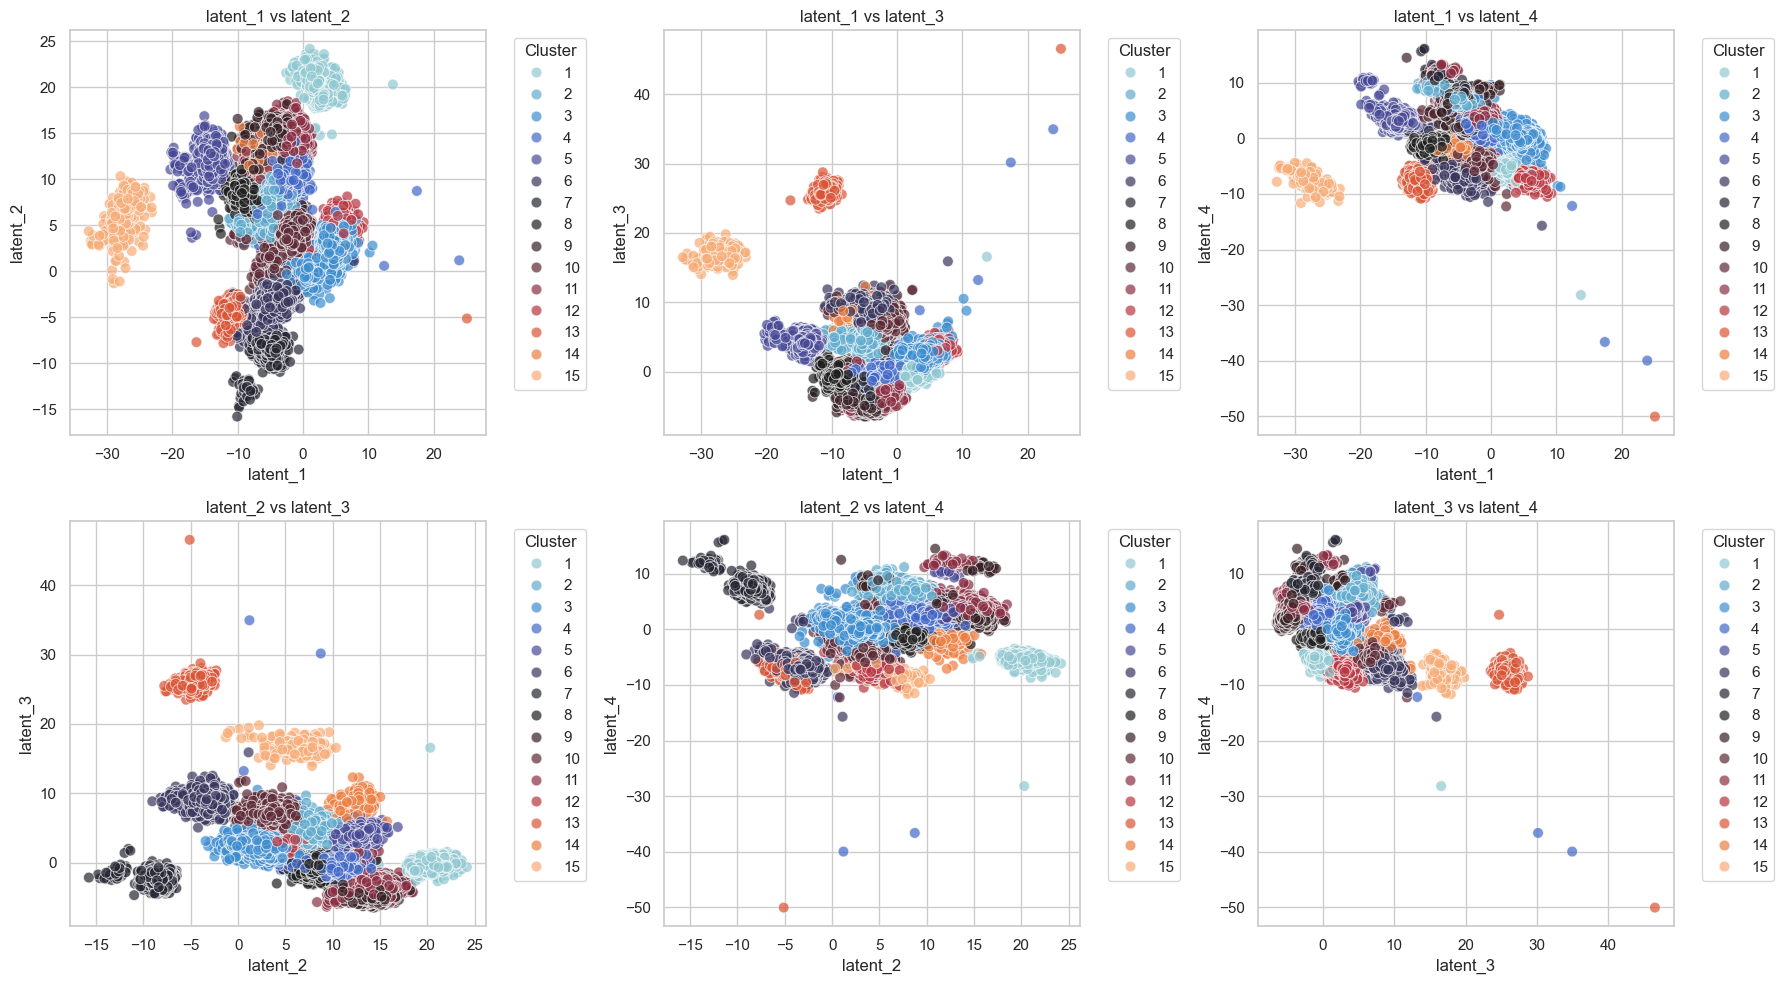

In [107]:
plot_clustering_latent(df_latent_representations, optimal_k)

In [108]:
pca_ae, pca_transformed_ae = run_pca(df_latent_representations, df_latent_representations.shape[1])
df_pca_ae = pd.DataFrame(pca_transformed_ae[:, :df_latent_representations.shape[1]], columns=[f'PC{i+1}' for i in range(df_latent_representations.shape[1])])
df_pca_ae['cluster'] = df_latent_representations['cluster']

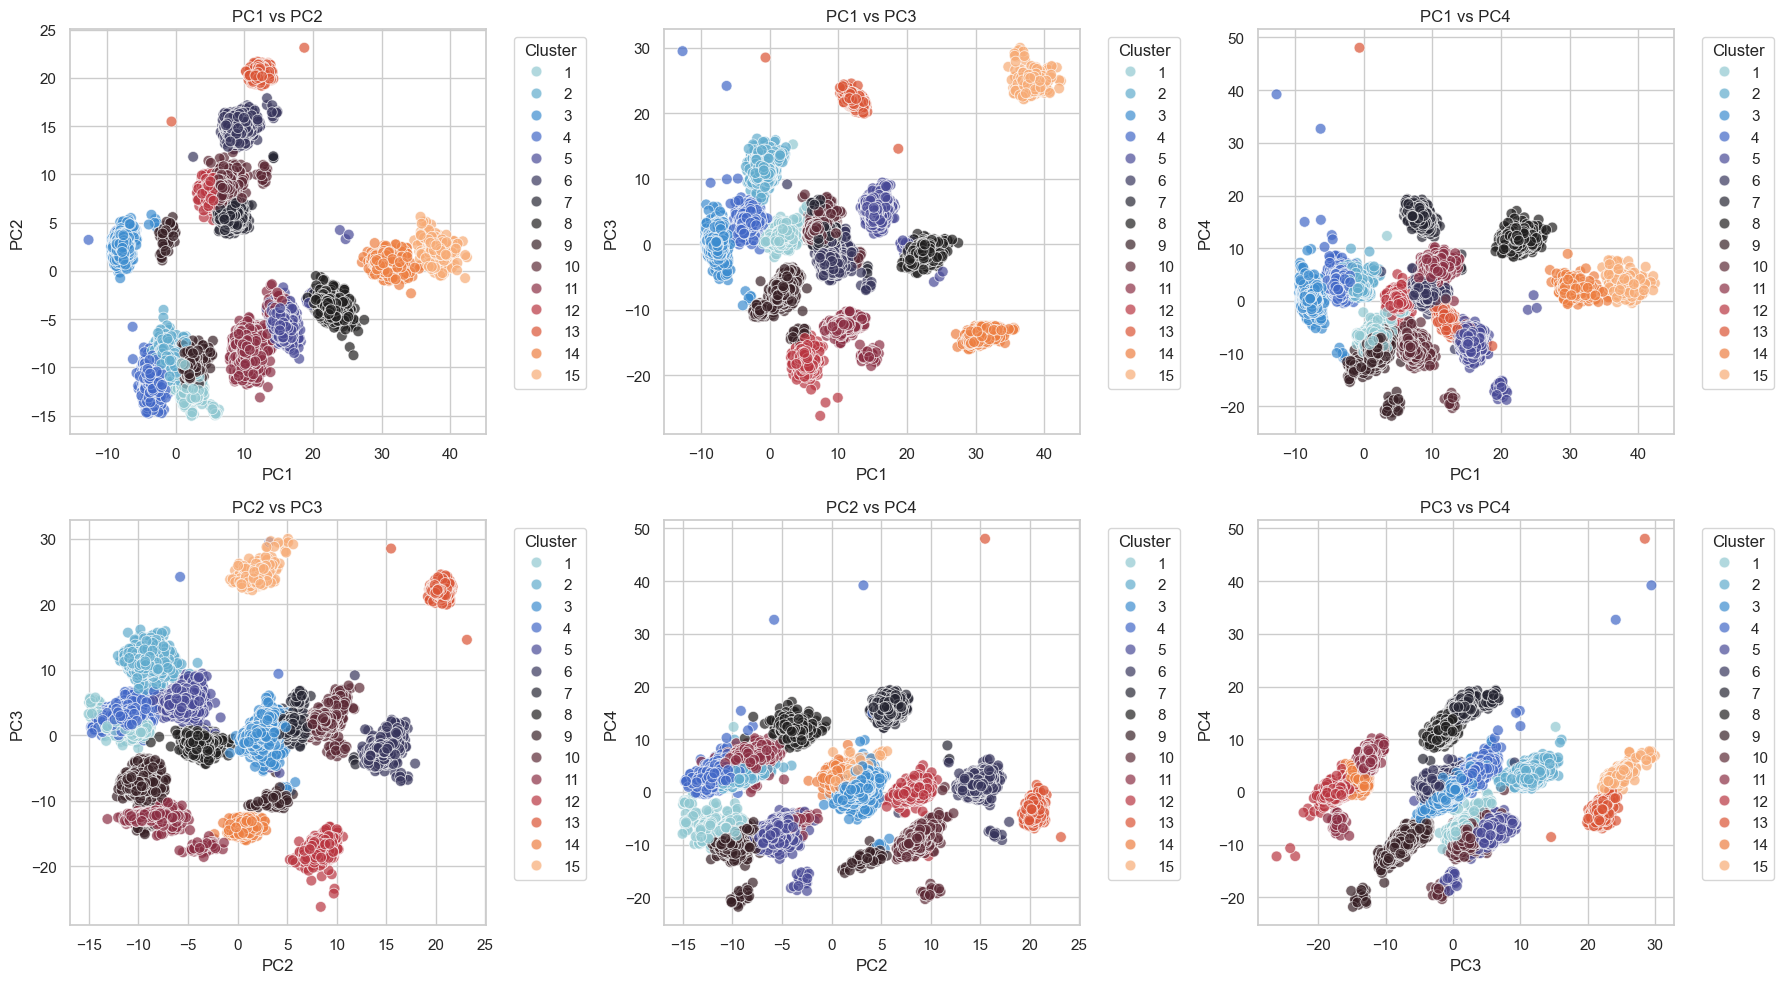

In [109]:
plot_pca_clustering(df_pca_ae, optimal_k)

In [42]:
# Evaluate performance
silhouette_score_ae = silhouette_score(df_latent_representations.drop(columns=['cluster']), df_latent_representations['cluster'])
davies_bouldin_ae = davies_bouldin_score(df_latent_representations.drop(columns=['cluster']), df_latent_representations['cluster'])

print(f"Silhouette Score: {silhouette_score_ae:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_ae:.4f}")

Silhouette Score: 0.7747
Davies-Bouldin Index: 0.2999


- Given the three approaches, the K-Means clustering with Autoencoder outperforms the other two methods in terms of Silhouette Score and Davies-Bouldin score.
- Also, in terms of visualizing the clusters, the clusters are more separated and distinct compared to the other two methods.
- Thus, we will use the K-Means clustering with Autoencoder to cluster the songs into clusters and use these clusters to recommend songs to users.

## 3.4: Recommendation based on clustering

Using our best-performing clustering method, *Autoencoder combined with K-Means*, we will recommend songs to users based on their listening history. The recommendation process is as follows:

**Identifying Relevant Clusters:**  
- For each user in the test set, we identify the top *k* clusters associated with the songs they have listened to. For each cluster, we calculate the proportion of songs the user has already heard in that cluster relative to their total listening history. This proportion determines how many songs from each cluster should be recommended. A higher proportion indicates that the user is more likely to enjoy songs from that cluster.

**Recommending Songs:**  
- From the identified clusters, we recommend songs that the user has not previously listened to. For each user and cluster, we compute a **personalized centroid point** by taking the mean of the latent representations of the songs in the cluster that the user has listened to. This centroid represents the user’s interaction with the cluster. Songs closest to this centroid (based on distance) are prioritized, ensuring that the recommendations are most relevant to the user. The final recommendations are sorted by distance to the centroid, with the closest songs recommended first.


In [88]:
cols_clustering = ['song_id','artist_familiarity', 'artist_hotttnesss','artist_latitude','artist_longitude','artist_freq',
                    'duration', 'loudness', 'tempo', 'time_signature', 'key', 'mode', 'song_hotttnesss', 'end_of_fade_in','start_of_fade_out','release_freq',
                    'genre_Blues','genre_Country', 'genre_Electronic', 'genre_Folk', 'genre_Jazz','genre_Latin', 'genre_Metal', 'genre_New Age', 
                    'genre_Pop','genre_Punk', 'genre_Rap', 'genre_Reggae', 'genre_RnB', 'genre_Rock','genre_World']
df_recommend = df_songs_cleaned[cols_clustering]
df_recommend['cluster'] = df_latent_representations['cluster']

In [ ]:
def calculate_top_k_clusters_with_ratios(listened_songs_split, df_recommend, k=3):
    """
    For each user, identify the top k clusters based on the number of songs listened to,
    and calculate the ratio of songs in each of these clusters, summing to 100%.
    
    Parameters:
    - listened_songs_split (pd.DataFrame): DataFrame with 'user_id' and 'song_id'.
    - df_clustering (pd.DataFrame): DataFrame with 'song_id' and 'cluster'.
    - k (int): Number of top clusters to identify per user.
    
    Returns:
    - pd.DataFrame: DataFrame with 'user_id' and columns for each top cluster's ID and ratio.
    """
    
    # Step 1: Merge the DataFrames on 'song_id'
    merged_df = listened_songs_split.merge(df_recommend, on='song_id', how='left')
    
    # Check for any songs that didn't merge correctly
    if merged_df['cluster'].isnull().any():
        missing_clusters = merged_df[merged_df['cluster'].isnull()]['song_id'].unique()
        print(f"Warning: The following song_ids do not have a corresponding cluster and will be excluded: {missing_clusters}")
        merged_df = merged_df.dropna(subset=['cluster'])
    
    # Step 2: Group by 'user_id' and 'cluster' and count the number of songs
    grouped = merged_df.groupby(['user_id', 'cluster']).size().reset_index(name='count')
    
    # Step 3: For each user, sort clusters by count descending and assign rank
    grouped_sorted = grouped.sort_values(['user_id', 'count'], ascending=[True, False])
    grouped_sorted['rank'] = grouped_sorted.groupby('user_id')['count'].rank(method='first', ascending=False).astype(int)
    
    # Select only top k clusters per user
    top_k = grouped_sorted[grouped_sorted['rank'] <= k]
    
    # Step 4: Calculate the total counts for top k clusters per user
    top_k['total_top_k'] = top_k.groupby('user_id')['count'].transform('sum')
    
    # Calculate the ratio for each top cluster
    top_k['ratio'] = (top_k['count'] / top_k['total_top_k']) * 100
    
    # Step 5: Pivot the DataFrame to have separate columns for each top cluster's ID and ratio
    # We'll create separate columns for cluster IDs and their corresponding ratios
    pivot_cluster = top_k.pivot(index='user_id', columns='rank', values='cluster')
    pivot_ratio = top_k.pivot(index='user_id', columns='rank', values='ratio')
    
    # Rename the columns to reflect their rank
    pivot_cluster = pivot_cluster.rename(columns=lambda x: f'cluster_top_{x}')
    pivot_ratio = pivot_ratio.rename(columns=lambda x: f'ratio_{x}')
    
    # Step 6: Combine the cluster IDs and ratios into a single DataFrame
    result_df = pivot_cluster.join(pivot_ratio).reset_index().rename_axis(None, axis=1)
    
    # Handle users with fewer than k clusters by filling NaN with appropriate values
    for i in range(1, k+1):
        cluster_col = f'cluster_top_{i}'
        ratio_col = f'ratio_{i}'
        if cluster_col not in result_df.columns:
            result_df[cluster_col] = pd.NA
        if ratio_col not in result_df.columns:
            result_df[ratio_col] = pd.NA
        
    # Optional: Sort the columns for better readability
    cols = ['user_id']
    for i in range(1, k+1):
        cols.extend([f'cluster_top_{i}', f'ratio_{i}'])
    result_df = result_df[cols]
    
    return result_df


In [117]:
# Calculate top 3 cluster ratios per user
listened_songs_split = pd.read_csv('data/processed/listened_songs_fixed_split.csv') # Load the played songs for the test users
cluster_user = calculate_top_k_clusters_with_ratios(listened_songs_split, df_recommend, k=3)

/Users/jasmink.j.thari/.local/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [118]:
cluster_user.head()

,user_id,cluster_top_1,ratio_1,cluster_top_2,ratio_2,cluster_top_3,ratio_3
0,0003a64f7a69e5b87a80b09c3772227185c235c7,3.0,64.583333,12.0,27.083333,10.0,8.333333
1,00053fba2e2651242dbce9b4f73b620b4eda990a,3.0,85.714286,2.0,14.285714,NaN,NaN
2,0009dc26c4ae94eb9409a726c26d3fe749f6faa1,3.0,71.428571,9.0,14.285714,11.0,14.285714
3,000e8ae5694b5ffd54287c53e8a0ec3cc44e9667,3.0,40.000000,10.0,33.333333,5.0,26.666667
4,000f1280e22b190d6840ba3f1524fa6872304e1b,3.0,50.000000,4.0,28.571429,5.0,21.428571


In [116]:
df_latent_representations['song_id'] = df_songs_cleaned['song_id']
df_latent_user_centroids = pd.merge(df_latent_representations, listened_songs_split, on='song_id', how='inner')
df_latent_user_centroids = df_latent_user_centroids.groupby(['user_id', 'cluster']).mean().reset_index()

In [119]:
def recommend_songs_centroid_based(cluster_user, 
                                    df_latent_user_centroids, 
                                    df_latent_representations, 
                                    k_songs, 
                                    listened_songs_split):
    """
    Recommend songs to users based on their cluster ratios and listening history using centroid-based selection.
    Includes both recommended song IDs and their corresponding distance scores.
    
    Parameters:
    - cluster_user (pd.DataFrame): DataFrame with 'user_id', 'cluster_top_1', 'ratio_1', ..., 'cluster_top_3', 'ratio_3'.
    - df_latent_user_centroids (pd.DataFrame): DataFrame with 'user_id', 'cluster', 'latent_1', ..., 'latent_10'.
    - df_latent_representations (pd.DataFrame): DataFrame with 'song_id', 'cluster', 'latent_1', ..., 'latent_10'.
    - k_songs (int): The number of songs to recommend.
    - listened_songs_split (pd.DataFrame): DataFrame with 'user_id' and 'song_id'.
    
    Returns:
    - recommendations_df (pd.DataFrame): DataFrame with 'user_id', 'recommended_songs' (list of song_ids), and 'scores' (list of distances).
    """
    recommendations = []
    
    # Define latent dimensions
    latent_dimensions = [f'latent_{i}' for i in range(1, 11)]
    
    # Create a dictionary mapping cluster_id to its songs' latent vectors and song_ids
    cluster_to_songs = {}
    for cluster_id, group in df_latent_representations.groupby('cluster'):
        song_ids = group['song_id'].tolist()
        song_vectors = group[latent_dimensions].values.astype(float)  # Ensure float type
        cluster_to_songs[cluster_id] = {'song_ids': song_ids, 'vectors': song_vectors}
    
    # Create a dictionary for user listened songs for quick lookup
    user_listened_dict = listened_songs_split.groupby('user_id')['song_id'].apply(set).to_dict()
    
    # Create a dictionary for user centroids per cluster
    user_centroids = {}
    for _, row in df_latent_user_centroids.iterrows():
        user_id = row['user_id']
        cluster_id = row['cluster']
        centroid_vector = row[latent_dimensions].values.astype(float).flatten()  # Ensure float type
        if user_id not in user_centroids:
            user_centroids[user_id] = {}
        user_centroids[user_id][cluster_id] = centroid_vector
    
    # Iterate over each user in cluster_ratio_user
    for idx, user_row in cluster_user.iterrows():
        user_id = user_row['user_id']
        # Extract top clusters and ratios
        cluster_tops = [user_row.get(f'cluster_top_{i}', np.nan) for i in range(1, 4)]
        ratios = [user_row.get(f'ratio_{i}', 0) for i in range(1, 4)]
        
        # Filter out invalid clusters and normalize ratios
        clusters_and_ratios = [(c, r) for c, r in zip(cluster_tops, ratios) if pd.notnull(c) and r > 0]
        if not clusters_and_ratios:
            continue  # Skip if no valid clusters
        cluster_tops_filtered, ratios_filtered = zip(*clusters_and_ratios)
        total_ratio = sum(ratios_filtered)
        ratios_normalized = [r / total_ratio for r in ratios_filtered]
        
        # Calculate number of songs to recommend from each cluster
        song_numbers = [int(np.floor(k_songs * r)) for r in ratios_normalized]
        
        # Adjust song_numbers to sum to k_songs
        remainder = k_songs - sum(song_numbers)
        if remainder > 0:
            remainders = [k_songs * r - sn for r, sn in zip(ratios_normalized, song_numbers)]
            for _ in range(remainder):
                idx_max_remain = np.argmax(remainders)
                song_numbers[idx_max_remain] += 1
                remainders[idx_max_remain] = 0  # Avoid selecting the same index again
        
        # Get user's listened songs
        listened_songs = user_listened_dict.get(user_id, set())
        
        user_recommendations = []
        user_scores = []
        unallocated_songs_needed = 0
        
        for cluster_id, num_songs in zip(cluster_tops_filtered, song_numbers):
            if num_songs <= 0:
                continue
            # Retrieve songs and vectors for the cluster
            songs_info = cluster_to_songs.get(cluster_id, None)
            if not songs_info:
                unallocated_songs_needed += num_songs
                continue  # No songs available in this cluster
            
            song_ids = songs_info['song_ids']
            song_vectors = songs_info['vectors']
            
            # Retrieve user's centroid for this cluster
            centroid = user_centroids.get(user_id, {}).get(cluster_id, None)
            if centroid is None:
                unallocated_songs_needed += num_songs
                continue  # No centroid available for this user in this cluster
            
            # Compute distances between centroid and all songs in the cluster using scipy's cdist
            try:
                distances = cdist(song_vectors, centroid.reshape(1, -1), metric='cosine').flatten()
            except Exception as e:
                print(f"Error computing distances for user {user_id} in cluster {cluster_id}: {e}")
                unallocated_songs_needed += num_songs
                continue
            
            # Create a DataFrame for sorting
            df_distances = pd.DataFrame({
                'song_id': song_ids,
                'distance': distances
            })
            
            # Exclude already listened songs and already recommended songs
            df_distances = df_distances[~df_distances['song_id'].isin(listened_songs)]
            df_distances = df_distances[~df_distances['song_id'].isin(user_recommendations)]
            
            # Sort by distance (ascending)
            df_distances_sorted = df_distances.sort_values(by='distance')
            
            # Select top N songs
            top_songs_df = df_distances_sorted[['song_id', 'distance']].head(num_songs)
            top_songs = top_songs_df['song_id'].tolist()
            top_distances = top_songs_df['distance'].tolist()
            
            # Append to recommendations
            user_recommendations.extend(top_songs)
            user_scores.extend(top_distances)
            
            # If not enough songs, track the unallocated number
            actual_recommended = len(top_songs)
            if actual_recommended < num_songs:
                unallocated_songs_needed += (num_songs - actual_recommended)
        
        # Allocate any unallocated songs from other clusters
        if unallocated_songs_needed > 0:
            # Identify other clusters not in the top clusters
            top_clusters_set = set(cluster_tops_filtered)
            other_clusters = set(cluster_to_songs.keys()) - top_clusters_set
            
            # Aggregate all songs from other clusters
            other_songs = []
            for cluster_id in other_clusters:
                songs_info = cluster_to_songs.get(cluster_id, {})
                if not songs_info:
                    continue
                other_songs.extend(songs_info['song_ids'])
            
            # Exclude listened songs and already recommended songs
            remaining_songs = list(set(other_songs) - listened_songs - set(user_recommendations))
            if remaining_songs:
                # For simplicity, randomly select from remaining_songs
                try:
                    num_extra = min(unallocated_songs_needed, len(remaining_songs))
                    extra_songs = np.random.choice(remaining_songs, size=num_extra, replace=False)
                    user_recommendations.extend(extra_songs)
                    # Assign a default score for these extra songs, e.g., None
                    user_scores.extend([None]*num_extra)
                except Exception as e:
                    print(f"Error allocating extra songs for user {user_id}: {e}")
        
        # Ensure the total number of recommendations is k_songs
        user_recommendations = user_recommendations[:k_songs]
        user_scores = user_scores[:k_songs]
        
        # Append to the recommendations list
        recommendations.append({
            'user_id': user_id,
            'recommended_songs': user_recommendations,
            'scores': user_scores
        })
    
    # Create the final recommendations DataFrame
    recommendations_df = pd.DataFrame(recommendations)
    return recommendations_df



In [120]:
# Parameters
k_songs = 50  # Number of songs to recommend per user
recommendations_df = recommend_songs_centroid_based(
    cluster_user=cluster_user,
    df_latent_user_centroids=df_latent_user_centroids,
    df_latent_representations=df_latent_representations,
    k_songs=k_songs,
    listened_songs_split=listened_songs_split
)

In [121]:
recommendations_df.head()

,user_id,recommended_songs,scores
0,0003a64f7a69e5b87a80b09c3772227185c235c7,"[SOAHQEC12A6D4F96A6, SOIRGDU12A58A7A101, SOSUG...","[0.0010022083478169463, 0.001201931149442781, ..."
1,00053fba2e2651242dbce9b4f73b620b4eda990a,"[SOFXPJJ12AB0187354, SOBKPCM12AF729D82E, SORJU...","[0.0009052376828897479, 0.00107327824283443, 0..."
2,0009dc26c4ae94eb9409a726c26d3fe749f6faa1,"[SOLSHEM12AF72A0FEE, SOZSSVR12A8C13D052, SOMFN...","[0.001136980347639427, 0.001265282079072727, 0..."
3,000e8ae5694b5ffd54287c53e8a0ec3cc44e9667,"[SOFYEDU12A6D4FB02B, SOALKHG12A6D4F32B7, SOCGI...","[0.001212580001834218, 0.0014009651979259852, ..."
4,000f1280e22b190d6840ba3f1524fa6872304e1b,"[SOTUKPX12A6D4F9E94, SOMUXCO12A8C134C2A, SOJVV...","[0.001155688756022788, 0.0012099429991718758, ..."


In [122]:
def softmax(scores):
    scores_exp = np.exp(scores - np.max(scores))  # Stability trick to prevent overflow
    return scores_exp / scores_exp.sum()

# Apply softmax row-wise
recommendations_df['probabilities'] = recommendations_df['scores'].apply(lambda x: softmax(np.array(x)))

In [123]:
recommendations_df.head()

,user_id,recommended_songs,scores,probabilities
0,0003a64f7a69e5b87a80b09c3772227185c235c7,"[SOAHQEC12A6D4F96A6, SOIRGDU12A58A7A101, SOSUG...","[0.0010022083478169463, 0.001201931149442781, ...","[0.019989353492799164, 0.019993346221187615, 0..."
1,00053fba2e2651242dbce9b4f73b620b4eda990a,"[SOFXPJJ12AB0187354, SOBKPCM12AF729D82E, SORJU...","[0.0009052376828897479, 0.00107327824283443, 0...","[0.019977010016414568, 0.01998036724643125, 0...."
2,0009dc26c4ae94eb9409a726c26d3fe749f6faa1,"[SOLSHEM12AF72A0FEE, SOZSSVR12A8C13D052, SOMFN...","[0.001136980347639427, 0.001265282079072727, 0...","[0.019983608749588287, 0.01998617284567661, 0...."
3,000e8ae5694b5ffd54287c53e8a0ec3cc44e9667,"[SOFYEDU12A6D4FB02B, SOALKHG12A6D4F32B7, SOCGI...","[0.001212580001834218, 0.0014009651979259852, ...","[0.019997087034583767, 0.020000854544606452, 0..."
4,000f1280e22b190d6840ba3f1524fa6872304e1b,"[SOTUKPX12A6D4F9E94, SOMUXCO12A8C134C2A, SOJVV...","[0.001155688756022788, 0.0012099429991718758, ...","[0.0200020470971962, 0.020003132322561668, 0.0..."


In [ ]:
def sort_recommendations(df):
    """
    Sorts the recommended songs, scores, and probabilities in the DataFrame based on probabilities.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'recommended_songs', 'scores', and 'probabilities' columns.

    Returns:
        pd.DataFrame: DataFrame with sorted 'recommended_songs', 'scores', and 'probabilities'.
    """
    sorted_recommendations = []

    for idx, row in df.iterrows():
        # Extract the lists
        songs = row['recommended_songs']
        scores = row['scores']
        probabilities = row['probabilities']

        # Combine them into a list of tuples
        combined = list(zip(songs, scores, probabilities))

        # Sort the combined list based on probabilities
        combined_sorted = sorted(combined, key=lambda x: x[2], reverse=True)

        # Unzip the sorted list back into separate lists
        sorted_songs, sorted_scores, sorted_probabilities = zip(*combined_sorted)

        # Append the sorted lists to the new DataFrame
        sorted_recommendations.append({
            'user_id': row['user_id'],
            'recommended_songs': list(sorted_songs),
            'scores': list(sorted_scores),
            'probabilities': list(sorted_probabilities)
        })

    return pd.DataFrame(sorted_recommendations)

# Apply the sorting function to the recommendations DataFrame
recommendations_df_sorted = sort_recommendations(recommendations_df)

In [134]:
recommendations_df_sorted.to_csv('data/processed/recommendations_clustering_df.csv', index=False)

## 3.4: Evaluate Clustering-based Recommendation

In [57]:
def evaluate_recommendations(recommendations_df, masked_songs_df, list_of_ks = [10,20,30,40,50]):
    """
    Evaluate the recommendations using Recall@k.
    Each user should prefable have 50 recommendations.
    
    Parameters:
    - recommendations_df (pd.DataFrame): DataFrame with 'user_id' and 'recommended_songs' (list of song_ids).
    - masked_songs_df (pd.DataFrame): DataFrame with 'user_id' and 'song_id' of masked songs.
    - ks (list): List of integers with the values of k to compute Recall@k.
    
    Returns:
    - evaluation_df (pd.DataFrame): DataFrame with 'user_id', and 'k_i' columns for each k in ks.   
    """
    # Ensure the recommended_songs are lists
    recommendations_df['recommended_songs'] = recommendations_df['recommended_songs'].apply(list)
    
    # Group masked songs by user
    masked_songs_grouped = masked_songs_df.groupby('user_id')['song_id'].apply(set).reset_index()
    masked_songs_dict = dict(zip(masked_songs_grouped['user_id'], masked_songs_grouped['song_id']))
    
    evaluation_results = []
    
    for _, row in recommendations_df.iterrows():
        user_id = row['user_id']
        # Get the masked songs for the user
        masked_songs = masked_songs_dict.get(user_id, set())
        recalls = []
        for k in list_of_ks:
            recommended_songs = row['recommended_songs'][:k]   
            if not masked_songs:
                # If there are no masked songs for the user, we cannot compute recall
                recall_at_k = None
            else:
                # Compute the number of relevant recommended songs
                relevant_recommendations = set(recommended_songs) & masked_songs
                num_relevant = len(relevant_recommendations)

                # Recall@k
                recall_at_k = num_relevant / len(masked_songs) if len(masked_songs) > 0 else 0

            recalls.append(recall_at_k)

        recall_dict = {f"k_{k}": recall_at_k for k, recall_at_k in zip(list_of_ks, recalls)}

        evaluation_results.append({
            'user_id': user_id,
            **recall_dict
        })

    evaluation_df = pd.DataFrame(evaluation_results)
    return evaluation_df

In [142]:
def evaluate_cluster_coverage(cluster_ratio_user, df_recommend, masked_songs_df):
    """
    Evaluate how many of the masked songs are in the users' cluster preferences.
    
    Parameters:
    - cluster_ratio_user (pd.DataFrame): DataFrame with 'user_id', 'cluster_top_1', 'ratio_1', 'cluster_top_2', 'ratio_2', 'cluster_top_3', 'ratio_3'.
    - df_recommend (pd.DataFrame): DataFrame with 'song_id' and 'cluster'.
    - masked_songs_df (pd.DataFrame): DataFrame with 'user_id' and 'song_id' of masked songs.
    
    Returns:
    - coverage_df (pd.DataFrame): DataFrame with 'user_id' and 'proportion_in_top_clusters'.
    """
    # Map song_id to cluster
    song_cluster_dict = df_recommend.set_index('song_id')['cluster'].to_dict()
    
    # Group masked songs by user
    masked_songs_grouped = masked_songs_df.groupby('user_id')['song_id'].apply(list).reset_index()
    masked_songs_dict = dict(zip(masked_songs_grouped['user_id'], masked_songs_grouped['song_id']))
    
    coverage_results = []
    
    for _, user_row in cluster_ratio_user.iterrows():
        user_id = user_row['user_id']
        cluster_tops = [
            int(user_row['cluster_top_1']) if pd.notnull(user_row['cluster_top_1']) else None,
            int(user_row['cluster_top_2']) if pd.notnull(user_row['cluster_top_2']) else None,
            int(user_row['cluster_top_3']) if pd.notnull(user_row['cluster_top_3']) else None
        ]
        # Filter out None values
        cluster_tops = [c for c in cluster_tops if c is not None]
        
        # Get the user's masked songs
        user_masked_songs = masked_songs_dict.get(user_id, [])
        if not user_masked_songs:
            continue  # Skip users with no masked songs
        
        # Map masked songs to clusters
        masked_song_clusters = [song_cluster_dict.get(song_id) for song_id in user_masked_songs]
        
        # Count how many masked songs are in user's top clusters
        count_in_top_clusters = sum(1 for cluster in masked_song_clusters if cluster in cluster_tops)
        total_masked_songs = len(user_masked_songs)
        
        # Calculate proportion
        proportion_in_top_clusters = count_in_top_clusters / total_masked_songs if total_masked_songs > 0 else 0
        
        coverage_results.append({
            'user_id': user_id,
            'proportion_in_top_clusters': proportion_in_top_clusters,
            'total_masked_songs': total_masked_songs,
            'count_in_top_clusters': count_in_top_clusters
        })
    
    coverage_df = pd.DataFrame(coverage_results)
    return coverage_df

In [34]:
masked_songs_split = data_loader.load_csv_file(data_path='data/processed/masked_songs_fixed_split.csv')

In [143]:
coverage_df = evaluate_cluster_coverage(cluster_user, df_recommend, masked_songs_split)
mean_proportion = coverage_df['proportion_in_top_clusters'].mean()
print(f"Mean Proportion of Masked Songs in Top Clusters: {mean_proportion:.4f}")


Mean Proportion of Masked Songs in Top Clusters: 0.8459


In [209]:
evaluation_df = evaluate_recommendations(recommendations_df_sorted, masked_songs_split)
print(f"Mean Recall@k:")
evaluation_df.mean().to_frame().T

Mean Recall@k:


,k_10,k_20,k_30,k_40,k_50
0,0.004806,0.010852,0.018762,0.028384,0.043211


# 4. Collaborative Filtering

Collaborative filtering is a recommendation technique that predicts user preferences by finding patterns in shared behaviors. This project uses user-based collaborative filtering, identifying similar users based on interaction history to recommend items they like. Key steps include creating a utility matrix, calculating user similarity (cosine similarity), finding top-5 similar users, generating recommendations, and evaluating them with Precision and Recall. This method provides personalized, data-driven recommendations efficiently.

## 4.1 Initialise utility matrix
In this section we map user and song IDs to matrix indices for training and testing data. But due to the large data size, we create a sparse utility matrix, for more efficient memory usage, using scipys function csr_matrix.

In [ ]:
def create_utility_matrices(train_users_songs, test_users_songs, n_users, seed=42):
    """
    Create train and test utility matrices using a sample of n users from training data.
    
    Args:
        train_users_songs (pd.DataFrame): Training data with user-song interactions
        test_users_songs (pd.DataFrame): Test data with user-song interactions  
        n_users (int): Number of users to sample from training data
        seed (int): Random seed for reproducibility
        
    Returns:
        train_utility_matrix (csr_matrix): Sparse matrix of training data
        test_utility_matrix (csr_matrix): Sparse matrix of test data
        train_user_ids (dict): Mapping of user IDs to indices
        train_song_ids (dict): Mapping of song IDs to indices
    """
    # Sample subset of users from train data
    sample_users = train_users_songs['user_id'].drop_duplicates().sample(n=n_users, random_state=seed)
    
    # Filter train data to sampled users
    sampled_train_df = train_users_songs[train_users_songs['user_id'].isin(sample_users)]
    
    # Create ID mappings
    train_user_ids = dict(zip(sampled_train_df['user_id'].unique(), range(len(sampled_train_df['user_id'].unique()))))
    train_song_ids = dict(zip(sampled_train_df['song_id'].unique(), range(len(sampled_train_df['song_id'].unique()))))
    
    print('Creating train utility matrix...')
    train_utility_matrix = csr_matrix(
        (sampled_train_df['play_count'],
         (sampled_train_df['user_id'].map(train_user_ids),
          sampled_train_df['song_id'].map(train_song_ids)))
    )
    
    # Handle test data
    test_user_ids = dict(zip(test_users_songs['user_id'].unique(), range(len(test_users_songs['user_id'].unique()))))
    test_users_songs_copy = test_users_songs.copy()
    test_users_songs_copy['song_idx'] = test_users_songs_copy['song_id'].map(train_song_ids).fillna(-1).astype(int)
    test_users_songs_filtered = test_users_songs_copy[test_users_songs_copy['song_idx'] >= 0]
    
    print('Creating test utility matrix...')
    test_utility_matrix = csr_matrix(
        (test_users_songs_filtered['play_count'],
         (test_users_songs_filtered['user_id'].map(test_user_ids),
          test_users_songs_filtered['song_idx'])),
        shape=(len(test_user_ids), len(train_song_ids))
    )
    
    return train_utility_matrix, test_utility_matrix, train_user_ids, train_song_ids, test_user_ids

In [9]:
train_user_df = pd.read_csv('data/processed/train_users.csv')  
user_data_cleaned_df = pd.read_csv('data/processed/user_data_cleaned.csv')
train_users_songs = user_data_cleaned_df[user_data_cleaned_df['user_id'].isin(train_user_df['user_id'])]
test_users_songs = pd.read_csv('data/processed/listened_songs_fixed_split.csv')
num_unique_users = train_users_songs['user_id'].nunique()

In [ ]:
train_matrix, test_matrix, train_user_ids, train_song_ids, test_user_ids = create_utility_matrices(train_users_songs, test_users_songs, num_unique_users)

## 4.2 Song Recommendation
Finding 5 similar users and recommend songs based on what the similar users listen to. Each test user is recommened 50 songs, and then each song is scored with the cosine similarity measure. 

In [13]:
def find_top_k_similar_users_optimized(train_matrix, test_matrix, train_user_ids, test_user_ids, K=5):
    """
    Optimized function to find the top K most similar users.
    """
    # Reverse the mappings for user IDs
    train_index_to_id = {v: k for k, v in train_user_ids.items()}
    test_index_to_id = {v: k for k, v in test_user_ids.items()}

    # Compute cosine similarity matrix between test and train users
    similarity_matrix = cosine_similarity(test_matrix, train_matrix)  # Shape: (n_test_users, n_train_users)

    top_k_results = {}

    # Efficiently find the top K indices for each test user
    top_k_indices = np.argpartition(-similarity_matrix, K - 1, axis=1)[:, :K]

    # Get the actual similarities for the top K indices and sort them
    for i in range(similarity_matrix.shape[0]):
        if i % 1000 == 0:
            print(f"Processing user {i + 1}/{similarity_matrix.shape[0]}")

        indices = top_k_indices[i]
        similarities = similarity_matrix[i, indices]
        sorted_idx = np.argsort(-similarities)
        top_indices = indices[sorted_idx]
        top_similarities = similarities[sorted_idx]

        # Map indices to user IDs
        test_user_id = test_index_to_id[i]
        top_k_results[test_user_id] = [
            {'train_user_id': train_index_to_id[idx], 'similarity_score': sim}
            for idx, sim in zip(top_indices, top_similarities)]
    return top_k_results

In [14]:
def recommend_weighted_songs_as_df(top_k_results, train_users_songs, test_users_songs, N=50):
    """
    Generate recommendations in a DataFrame format, including similarity scores for the recommended songs.

    Args:
        top_k_results: Output from find_top_k_similar_users, mapping test users to top K train users.
        train_users_songs: DataFrame with columns ['song_id', 'user_id', 'play_count'] for training data.
        test_users_songs: DataFrame with columns ['song_id', 'user_id', 'play_count'] for test data.
        N (int): Number of top-ranked songs to recommend for each test user.

    Returns:
        recommendations_df: DataFrame with columns ['user_id', 'recommended_songs', 'song_scores'].
    """
    # Create mappings for quick lookup
    train_user_songs = train_users_songs.groupby('user_id')['song_id'].apply(set).to_dict()
    test_user_songs = test_users_songs.groupby('user_id')['song_id'].apply(set).to_dict()

    recommendations = []
    total_users = len(top_k_results)

    # Iterate over test users and their top K similar users
    for idx, (test_user_id, similar_users) in enumerate(top_k_results.items()):
        # Print status every 1,000 users
        if idx % 1000 == 0:
            print(f"Processing test user {idx + 1}/{total_users}")

        # Get songs already listened to by the test user
        test_user_listened_songs = test_user_songs.get(test_user_id, set())
        
        # Initialize a dictionary to store scores for candidate songs
        song_scores = {}

        # Iterate over top K similar users
        for entry in similar_users:
            train_user_id = entry['train_user_id']
            similarity_score = entry['similarity_score']

            # Get songs listened to by the training user
            train_user_songs_set = train_user_songs.get(train_user_id, set())

            # For each song, assign the similarity score
            for song_id in train_user_songs_set:
                if song_id not in test_user_listened_songs:
                    # If the song hasn't been scored yet, set its score as the similarity score
                    # If it has been scored, keep the maximum similarity score
                    current_score = song_scores.get(song_id, 0)
                    song_scores[song_id] = max(current_score, similarity_score)

        # Rank the songs by their scores
        ranked_songs = sorted(song_scores.items(), key=lambda x: x[1], reverse=True)

        # Recommend the top-N songs and collect their scores
        recommended_songs = [song_id for song_id, score in ranked_songs[:N]]
        song_scores_list = [score for song_id, score in ranked_songs[:N]]

        # Append recommendations
        recommendations.append({
            'user_id': test_user_id,
            'recommended_songs': recommended_songs,
            'song_scores': song_scores_list
        })

    # Convert to DataFrame
    recommendations_df = pd.DataFrame(recommendations)
    return recommendations_df

In [ ]:
# Find the top K most similar training users for each test user
K = 5  # Number of neighbors
print(f"Finding similar k = {K} users, for each test user")
top_k_results = find_top_k_similar_users_optimized(train_matrix, test_matrix, train_user_ids, test_user_ids, K=K)

Finding similar k = 5 users, for each test user


In [ ]:
N = 50 # Number of top-ranked songs to recommend
recommendations_collaborative_df = recommend_weighted_songs_as_df(top_k_results, train_users_songs, test_users_songs, N=N)

In [53]:
# read the recommendations from collaborative filtering
recommendations_collaborative_df = pd.read_csv('results/recommendations_collab_fixed.csv')
recommendations_collaborative_df['song_scores'] = recommendations_collaborative_df['song_scores'].apply(ast.literal_eval)
recommendations_collaborative_df['recommended_songs'] = recommendations_collaborative_df['recommended_songs'].apply(ast.literal_eval)

In [54]:
# Apply softmax row-wise
recommendations_collaborative_df['probabilities'] = recommendations_collaborative_df['song_scores'].apply(lambda x: softmax(np.array(x)))

## 4.3 Evaluate Collaborative Filtering

In [58]:
evaluation_collab_df = evaluate_recommendations(recommendations_collaborative_df, masked_songs_split)
evaluation_collab_df.set_index('user_id', inplace=True)
print(f"Mean Recall@k:")
evaluation_collab_df.mean().to_frame().T

Mean Recall@k:


,k_10,k_20,k_30,k_40,k_50
0,0.040726,0.068961,0.088775,0.104008,0.116796


# 5. Apriori Algorithm

In this section, we’ll use the Apriori Algorithm to identify frequent itemsets of size 2. Based on the frequent itemsets, we will generate association rules to recommend songs to users based on the songs they have listened to. The association rules used are confidence and lift.

## 5.1 Sparse Matrix Representation

We use the `csr_matrix` class from the `scipy.sparse` module to represent the transaction matrix.
This allows us to save memory by only storing the non-zero elements of the matrix. The `csr_matrix` class is a sparse matrix representation that stores the matrix in Compressed Sparse Row format and it is efficient for matrix-vector multiplication, which is how we will find the frequent itemsets of size 2.

In [ ]:
def find_train_users(path_to_all_users_data: str, path_to_train_users_IDs: str, output_path: str) -> pd.DataFrame:
    # Read the data files
    listened_songs_all_users = pd.read_csv(path_to_all_users_data)
    train_users = pd.read_csv(path_to_train_users_IDs)["user_id"]
    # Filter the dataframe to include only users in the training set
    train_users_data = listened_songs_all_users[listened_songs_all_users["user_id"].isin(train_users)]
    # Save the filtered dataframe    
    train_users_data.to_csv(output_path, index=False)
    # Print the number of unique users
    print(f"Number of unique users in the training set: {train_users_data['user_id'].nunique()}")
    print(f"Number of unique songs in the training set: {train_users_data['song_id'].nunique()}")
    return train_users_data   

def create_sparse_matrix(path_to_train_users_data: str, transaction_matrix: bool = True):
    """
    Create a sparse matrix from a csv file with user data with columns song_id, user_id, play_count    
    Input:
    path_to_user_data: str, path to the user data
    transaction_matrix: bool, if True the play_count is set to 1, else the play_count is used as is
    Returns:
    sparse_matrix: csr_matrix, 
    user_id_mapping: dict, mapping from the integer codes to the original user ids
    song_id_mapping: dict, mapping from the integer codes to the original song ids
    """
    df = pd.read_csv(path_to_train_users_data)
    # Convert user_id and song_id to categories
    # this the pandas way of mapping strings as integers    
    df["user_id"] = df["user_id"].astype("category")
    df["song_id"] = df["song_id"].astype("category")

    # Extract the integer codes from the categories
    user_codes = df["user_id"].cat.codes
    song_codes = df["song_id"].cat.codes

    # mapping from the integer codes to the original strings
    user_id_mapping = dict(enumerate(df["user_id"].cat.categories))
    song_id_mapping = dict(enumerate(df["song_id"].cat.categories))
    
    if transaction_matrix:
        df["play_count"] = 1  
        # create of type bool to save memory      
        sparse_matrix = csr_matrix(
            (df["play_count"], (user_codes, song_codes)),
            shape=(df["user_id"].cat.categories.size, df["song_id"].cat.categories.size),
            dtype="bool"
        )
    else:
        sparse_matrix = csr_matrix(
            (df["play_count"], (user_codes, song_codes)),
            shape=(df["user_id"].cat.categories.size, df["song_id"].cat.categories.size),
            dtype="int32"
        )
        
    print(f"Created sparse matrix wih shape: {sparse_matrix.shape}")
    print(f"Memory usage of sparse matrix: {sparse_matrix.data.nbytes / 1024:.2f} KB")
    return sparse_matrix , user_id_mapping, song_id_mapping

In [153]:
PATH_ALL_USERS_DATA = "data/processed/user_data_cleaned.csv"
PATH_TRAIN_USERS_IDS = "data/processed/train_users.csv"
PATH_TRAIN_USERS_DATA = "data/processed/user_data_clean_train.csv"

In [155]:
train_users_data = find_train_users(PATH_ALL_USERS_DATA, PATH_TRAIN_USERS_IDS, PATH_TRAIN_USERS_DATA)
transaction_matrix, user_id_mapping, song_id_mapping = create_sparse_matrix(PATH_TRAIN_USERS_DATA, transaction_matrix=True)
TOTAL_NUMBER_OF_USERS = transaction_matrix.shape[0]

Number of unique users in the training set: 156236
Number of unique songs in the training set: 62066
Created sparse matrix wih shape: (156236, 62066)
Memory usage of sparse matrix: 6432.13 KB


## 5.2 Apriori Algorithm

Our implementation of the Apriori Algorithm to find frequent itemsets of size 2 is as follows:

1. Find the frequent singletons by summing the columns of the transaction matrix and remove the columns of the items which have a support less than the minimum support threshold. Save the frequent singletons.

2. Let A be the transaction matrix only containing the frequent singletons. Now take the matrix product of A and its transpose. The result of this matrix multiplication is a matrix where the element at position (i, j) is the number of transactions where both item i and item j are present. To select the frequent itemsets of size 2, we can extract the row and column indices of the elements that are greater than or equal to the minimum support threshold. Save the frequent itemsets of size 2.

In [ ]:
def apriori_algorithm_pairs(crs_matrix: csr_matrix, min_support: float, write_to_file: bool = True):                   
    """
    Apriori algorithm for pairs using crs_matrix and matrix multiplication
    Input: 
    crs_matrix: sparse matrix, the transaction matrix
    min_support: float, the minimum support
    write_to_file: bool, if True the frequent itemsets are written to a file
    """
    TOTAL_NUMBER_OF_USERS = crs_matrix.shape[0]
    SUPPORT_THRESHOLD = int(math.ceil(TOTAL_NUMBER_OF_USERS * min_support))
    WRITE_TO_FILE = write_to_file
    out_folder = "results"
    os.makedirs(out_folder, exist_ok=True)
    OUT_PATH = f"{out_folder}/frequent_itemsets_support_{min_support}.csv"
    # delete the file if it already exists
    if WRITE_TO_FILE and os.path.exists(OUT_PATH):
        os.remove(OUT_PATH)  
    
    # singletons           
    single_item_occurance = np.array(crs_matrix.sum(axis=0)).flatten()
    relevant_single_item_indices = np.where(single_item_occurance >= SUPPORT_THRESHOLD)[0]
    print(f"Number of single items above the threshold: {len(relevant_single_item_indices)}")
    filtered_csr_idx_to_org_item_idx = {new_index: old_index for new_index, old_index in enumerate(relevant_single_item_indices)}
    filtered_crs_matrix = crs_matrix[:,relevant_single_item_indices]
    # remove old matrix to free up memory
    frequent_singletons = {i: single_item_occurance[i] for i in relevant_single_item_indices}

    if WRITE_TO_FILE:
        with open(OUT_PATH, "a") as f:                
            for singleton, frequency in frequent_singletons.items():
                support = frequency / TOTAL_NUMBER_OF_USERS                             
                f.write(f"({singleton}),{support}\n")

    # pairs
    pairwise_occurance_matrix = filtered_crs_matrix.astype(np.int32).T @ filtered_crs_matrix.astype(np.int32)
    # only extract the lower triangle (excluding the diagonal) since the matrix is symmetric
    pairwise_occurance_matrix = tril(pairwise_occurance_matrix, k=-1)
    coo = pairwise_occurance_matrix.tocoo()
    mask = coo.data >= SUPPORT_THRESHOLD
    filtered_rows, filtered_cols, filtered_values = coo.row[mask], coo.col[mask], coo.data[mask]

    original_rows = [filtered_csr_idx_to_org_item_idx[i] for i in filtered_rows]
    original_cols = [filtered_csr_idx_to_org_item_idx[i] for i in filtered_cols]    

    frequent_pairs  = {}
    for row, col, value in zip(original_rows, original_cols, filtered_values):
        item_set = tuple(sorted((row, col)))
        assert item_set not in frequent_pairs, f"Key {item_set} is already in the dictionary, should not happen"            
        frequent_pairs[item_set] = value

    print(f"Number of pairs above the threshold: {len(frequent_pairs)}")
    if WRITE_TO_FILE:
        with open(OUT_PATH, "a") as f:                
            for itemset in frequent_pairs:
                # Ensure valid mapping of filtered indices to original item indices
                #original_item_indices = tuple(sorted([filtered_csr_idx_to_org_item_idx[i] for i in itemset]))                   
                support = frequent_pairs[itemset] / TOTAL_NUMBER_OF_USERS
                f.write(f"{itemset},{support}\n")        

    return frequent_singletons, frequent_pairs

In [157]:
MIN_SUPPORT = 0.001 # have been run with 0.001, 0,0005, 0.0001, 0.00005
freq_singletons, freq_pairs = apriori_algorithm_pairs(transaction_matrix, min_support=MIN_SUPPORT, write_to_file=True)

support_singletons = {item: freq_singletons[item] / TOTAL_NUMBER_OF_USERS for item in freq_singletons}
support_pairs = {item: freq_pairs[item] / TOTAL_NUMBER_OF_USERS for item in freq_pairs}

singleton_df = pd.DataFrame({"item": list(support_singletons.keys()), "support": list(support_singletons.values())})
pairs_df = pd.DataFrame({"itemset": list(support_pairs.keys()), "pair_support": list(support_pairs.values())})

Number of single items above the threshold: 9228
Number of pairs above the threshold: 47748


## 5.3 Association Rules

In [158]:
def calculate_confidence(support_A_and_B, support_A):
    return support_A_and_B / support_A

def calculate_lift(confidence_A_to_B, support_B):
    return confidence_A_to_B / support_B

pairs_df["item_A"] = pairs_df["itemset"].apply(lambda x: x[0])
pairs_df["item_B"] = pairs_df["itemset"].apply(lambda x: x[1])
pairs_df["support_A"] = pairs_df["item_A"].apply(lambda x: support_singletons[x])
pairs_df["support_B"] = pairs_df["item_B"].apply(lambda x: support_singletons[x])

In [159]:
pairs_df["confidence_A_to_B"] = pairs_df.apply(
    lambda x: calculate_confidence(x["pair_support"], x["support_A"]), axis=1
)
pairs_df["confidence_B_to_A"] = pairs_df.apply(
    lambda x: calculate_confidence(x["pair_support"], x["support_B"]), axis=1)

pairs_df["lift"] = pairs_df.apply(
    lambda x: calculate_lift(x["confidence_A_to_B"], x["support_B"]), axis=1
)
pairs_df.head()

,itemset,pair_support,item_A,item_B,support_A,support_B,confidence_A_to_B,confidence_B_to_A,lift
0,"(14, 55080)",0.001357,14,55080,0.002368,0.008634,0.572973,0.157153,66.359530
1,"(15, 42101)",0.001216,15,42101,0.003168,0.003924,0.383838,0.309951,97.829321
2,"(15, 58716)",0.001146,15,58716,0.003168,0.002944,0.361616,0.389130,122.820571
3,"(18, 39893)",0.001255,18,39893,0.008570,0.004474,0.146378,0.280401,32.717449
4,"(18, 53681)",0.001671,18,53681,0.008570,0.002880,0.194922,0.580000,67.675041


In [160]:
pairs_df["confidence_A_to_B"] = pairs_df.apply(
    lambda x: calculate_confidence(x["pair_support"], x["support_A"]), axis=1
)
pairs_df["confidence_B_to_A"] = pairs_df.apply(
    lambda x: calculate_confidence(x["pair_support"], x["support_B"]), axis=1)

pairs_df["lift"] = pairs_df.apply(
    lambda x: calculate_lift(x["confidence_A_to_B"], x["support_B"]), axis=1
)
pairs_df.head()

,itemset,pair_support,item_A,item_B,support_A,support_B,confidence_A_to_B,confidence_B_to_A,lift
0,"(14, 55080)",0.001357,14,55080,0.002368,0.008634,0.572973,0.157153,66.359530
1,"(15, 42101)",0.001216,15,42101,0.003168,0.003924,0.383838,0.309951,97.829321
2,"(15, 58716)",0.001146,15,58716,0.003168,0.002944,0.361616,0.389130,122.820571
3,"(18, 39893)",0.001255,18,39893,0.008570,0.004474,0.146378,0.280401,32.717449
4,"(18, 53681)",0.001671,18,53681,0.008570,0.002880,0.194922,0.580000,67.675041


In [161]:
# save to json file:
measurement_dict = {}

for _, row in pairs_df.iterrows():
    item1, item2 = song_id_mapping[row['item_A']], song_id_mapping[row['item_B']]
    conf1_to_2 = row['confidence_A_to_B']
    conf2_to_1 = row['confidence_B_to_A']
    lift = row['lift'] # remember lift_A_to_B == lift_B_to_A    
    # Add item1 -> item2 confidence
    if item1 not in measurement_dict:
        measurement_dict[item1] = {item2: {"confidence": conf1_to_2, "lift": lift}}   
    else:
        measurement_dict[item1][item2] = {"confidence": conf1_to_2, "lift": lift}
    
    # Add item2 -> item1 confidence
    if item2 not in measurement_dict:
        measurement_dict[item2] = {item1: {"confidence": conf2_to_1, "lift": lift}}   
    else:
        measurement_dict[item2][item1] = {"confidence": conf2_to_1, "lift": lift}

# Save to JSON file
with open(f"results/measurements_{MIN_SUPPORT}.json", "w") as json_file:
    json.dump(measurement_dict, json_file, indent=4)

print(f"Saved measurements to results/measurements_{MIN_SUPPORT}.json")

Saved measurements to results/measurements_0.001.json


In [163]:
# restructure the data such that the confidence and lift values are sorted in descending order
def restructure_data(data):
    result = {}
    
    for song, related_songs in data.items():
        # Collect confidence and lift values for each song
        confidence_list = sorted(
            [(related, values['confidence']) for related, values in related_songs.items()],
            key=lambda x: x[1], reverse=True
        )
        lift_list = sorted(
            [(related, values['lift']) for related, values in related_songs.items()],
            key=lambda x: x[1], reverse=True
        )
        
        result[song] = {
            'confidence': confidence_list,
            'lift': lift_list
        }
    
    return result

restructured_data = restructure_data(measurement_dict)

# save to json file:
with open(f"results/measurements_restructured_{MIN_SUPPORT}.json", "w") as json_file:
    json.dump(restructured_data, json_file, indent=4)

## 5.4 Recommendation based on Apriori Algorithm & Evaluation

To recommend songs to users based on the songs they have listened to, we use the association rules generated by the Apriori Algorithm. We use either confidence or lift metrics to generate the recommendations. For a given test user we have a list of songs that the user has listened to. Based on the users listened songs, we generate 50 song recommendations as follows:

1. For each song the user has listend to, we extract the songs that are associated with the listened song based on either confidence or lift values.

2. Remove the songs that the user has already listened to. Sort the remaining songs based on the confidence or lift values and select the top 50 songs as recommendations.

Finally the recommendations are evaluated using already defined evaluation metrics.

In [ ]:
PATH_TEST_DATA_FIXED = "data/processed/listened_songs_fixed_split.csv"
PATH_TEST_MASKED_FIXED = "data/processed/masked_songs_fixed_split.csv"

test_users_data_fixed = pd.read_csv(PATH_TEST_DATA_FIXED)
test_users_data_masked_fixed = pd.read_csv(PATH_TEST_MASKED_FIXED)

def group_data(data):
    """
    Group the data by user_id
    Input:
    data: pd.DataFrame, the data to group
    Returns:
    grouped_data: dict, the grouped data
    """
    grouped_data = data.groupby("user_id")["song_id"].apply(list).reset_index()
    grouped_data.columns = ['user_id', 'songs']
    return grouped_data

test_users_data_fixed = group_data(test_users_data_fixed)
test_users_data_masked_fixed = group_data(test_users_data_masked_fixed)
test_users_data_fixed = test_users_data_fixed.merge(test_users_data_masked_fixed, on="user_id", suffixes=('_listened', '_masked'))
test_users_data_fixed["num_songs_to_recommend"] = test_users_data_fixed["songs_masked"].apply(len)

In [166]:
def recommend_songs(restructured_data,known_songs,k,measurement_type='confidence',verbose=False):
    """
    Recommend k songs based on the known songs
    Input:
    restructured_data: dict, the restructured data that is sorted in descending order
    known_songs: list, the songs the user has listened to
    k: int, the number of songs to recommend
    measurement_type: str, the type of measurement to use, either 'confidence' or 'lift'
    Returns:
    recommended_songs: list, the recommended songs
    """
    # Collect the confidence values for the known songs    
    all_possible_recommendations = []
    for song in known_songs:
        try:
            related_songs = restructured_data[song][measurement_type]
            # remove the songs that are already known
            related_songs = [(related, confidence) for related, confidence in related_songs if related not in known_songs]
            all_possible_recommendations.extend(related_songs)
        except KeyError:
            if verbose:
                print(f"Song {song} is not in the dataset")
            continue
    # Sort the confidence values in descending order
    all_possible_recommendations = sorted(all_possible_recommendations, key=lambda x: x[1], reverse=True)
    # Collect the top k songs
    recommended_songs = [song_and_score for song_and_score in all_possible_recommendations[:k]]
    return recommended_songs

In [167]:
def add_and_remove_cols(df_in):
    #Make a copy of the dataframe
    df = df_in.copy()
    df["recommended_songs"] = df["recommended_songs_tuple"].apply(lambda x: [song for song, _ in x])
    df["scores"] = df["recommended_songs_tuple"].apply(lambda x: [confidence for _, confidence in x])
    df["probabilities"] = df["scores"].apply(lambda x: np.exp(x) / np.sum(np.exp(x)))
    # keep columns ['user_id', 'recommended_songs', 'recommended_songs_score', 'softmax_score']
    df = df[['user_id', 'recommended_songs', 'scores', 'probabilities']]
    return df

In [ ]:
# recommend songs for different measurement types and recommendation strategies
# also evaluate the recommendations
NUM_SONGS_TO_RECOMMEND = 50

test_labels_masked_fixed = pd.read_csv(PATH_TEST_MASKED_FIXED)

for measurement_type in ['confidence', 'lift']:    
    print(f"Measurement type: {measurement_type}")    
    test_users_data_fixed["recommended_songs_tuple"] = test_users_data_fixed.apply(
        lambda row: recommend_songs(restructured_data, 
                                    row["songs_listened"],
                                    NUM_SONGS_TO_RECOMMEND,                                       
                                    measurement_type=measurement_type), axis=1)                                    
    output_fixed = add_and_remove_cols(test_users_data_fixed)
    output_fixed.to_csv(f"results/recommendations_fixed_{measurement_type}_{MIN_SUPPORT}.csv", index=False)
    output_fixed.to_pickle(f"results/recommendations_fixed_{measurement_type}_{MIN_SUPPORT}.pkl")
    evaluation_fixed = evaluate_recommendations(output_fixed, 
                                                test_labels_masked_fixed) 
                                                
    evaluation_fixed.to_csv(f"results/evaluation_fixed_{measurement_type}_{MIN_SUPPORT}.csv", index=False)   

Measurement type: confidence
Measurement type: lift


In [233]:
supports = [0.001, 0.0005, 0.0001]
methods = ['confidence', 'lift']

data = []
for support in supports:
    for method in methods:
        file = f"results/evaluation_fixed_{method}_{support}.csv"
        mean_values = pd.read_csv(file).drop(columns=["user_id"]).mean()
        mean_values["method"] = method
        mean_values["support"] = support
        data.append(mean_values)
        
#final creation
final_df = pd.DataFrame(data).reset_index(drop=True)
# sort by support and method
final_df = final_df.sort_values(by=["support", "method"]).reset_index(drop=True)
# make method and support the first columns
final_df = final_df[["method", "support"] + [col for col in final_df.columns if col not in ["method", "support"]]]
final_df

,method,support,k_10,k_20,k_30,k_40,k_50
0,confidence,0.0001,0.156953,0.224492,0.268784,0.301309,0.326465
1,lift,0.0001,0.067148,0.104904,0.134564,0.158955,0.179813
2,confidence,0.0005,0.141647,0.198633,0.235547,0.262005,0.282497
3,lift,0.0005,0.080752,0.122320,0.153533,0.179243,0.200218
4,confidence,0.0010,0.124953,0.172523,0.202466,0.223498,0.240033
5,lift,0.0010,0.081387,0.122244,0.151864,0.174304,0.191843


# 6. Ensemble-Based Song Recommender System

In [ ]:
def ensemble_recommender(recommendations_cluster_df: pd.DataFrame, 
                         recommendations_collaborative_df: pd.DataFrame, 
                         recommendations_apriori_df: pd.DataFrame, 
                         k: int): 
    """
    Combines recommendations from multiple recommenders using a weighted ensemble approach.

    Parameters:
    - recommendations_cluster_df (pd.DataFrame): DataFrame with 'user_id', 'recommended_songs', 'scores', and 'probabilities'.
    - recommendations_collaborative_df (pd.DataFrame): DataFrame with 'user_id', 'recommended_songs', 'scores', and 'probabilities'.
    - recommendations_apriori_df (pd.DataFrame): DataFrame with 'user_id', 'recommended_songs', 'scores', and 'probabilities'.
    - k (int): The number of recommendations to recommend.

    Returns:
    - ensemble_df (pd.DataFrame): DataFrame with 'user_id', 'recommended_songs' (list of song_ids), and 'probabilities' (list of probabilities).
    """

    # Add method column to identify which method the recommendations came from
    recommendations_cluster_df['method'] = 'cluster'
    recommendations_collaborative_df['method'] = 'collaborative'
    recommendations_apriori_df['method'] = 'apriori'

    # Combine all recommendations into a single DataFrame
    all_recommendations = pd.concat([
        recommendations_cluster_df,
        recommendations_collaborative_df,
        recommendations_apriori_df
    ])

    # Explode the recommendations, probabilities, and methods for aggregation
    exploded = all_recommendations.explode(['recommended_songs', 'probabilities', 'method'])

    # Group by user_id and recommended song to aggregate frequencies and probabilities
    grouped = (
        exploded
        .groupby(['user_id', 'recommended_songs'], as_index=False)
        .agg(
            frequency=('recommended_songs', 'count'),  # Count how often each song is recommended
            avg_probability=('probabilities', 'mean'),  # Average probabilities
            methods=('method', lambda x: list(x))  # Collect methods
        )
    )

    # Create a column to indicate if the song is recommended by the apriori method
    grouped['is_apriori'] = grouped['methods'].apply(lambda x: 1 if 'apriori' in x else 0)

    # For sorting, use avg_probability only for apriori method; set to 0 otherwise
    grouped['prob_for_sorting'] = grouped.apply(
        lambda x: x['avg_probability'] if x['is_apriori'] == 1 else 0, axis=1
    )

    # For each user, sort by frequency, then is_apriori, then avg_probability
    sorted_recommendations = (
        grouped
        .sort_values(
            by=['user_id', 'frequency', 'is_apriori', 'prob_for_sorting'],
            ascending=[True, False, False, False]
        )
    )

    # Aggregate top k recommendations for each user
    top_k_recommendations = (
        sorted_recommendations
        .groupby('user_id')
        .head(k)  # Take top-k recommendations per user
        .groupby('user_id')
        .agg(
            recommended_songs=('recommended_songs', list),  # Collect song IDs as a list
            probabilities=('avg_probability', list)  # Collect probabilities as a list
        )
        .reset_index()
    )

    return top_k_recommendations


In [69]:
recommendations_cluster_df = pd.read_csv("results/recommendations_clustering_df.csv")
recommendations_collaborative_df = pd.read_csv("results/recommendations_collab_fixed.csv")
recommendations_apriori_df = pd.read_pickle("results/recommendations_fixed_confidence_0.0001.pkl")

In [70]:
recommendations_cluster_df['probabilities'] = recommendations_cluster_df['probabilities'].apply(ast.literal_eval)
recommendations_cluster_df['recommended_songs'] = recommendations_cluster_df['recommended_songs'].apply(ast.literal_eval)

recommendations_collaborative_df['song_scores'] = recommendations_collaborative_df['song_scores'].apply(ast.literal_eval)
recommendations_collaborative_df['recommended_songs'] = recommendations_collaborative_df['recommended_songs'].apply(ast.literal_eval)
recommendations_collaborative_df['probabilities'] = recommendations_collaborative_df['song_scores'].apply(lambda x: softmax(np.array(x)))

In [76]:
ensemble_recommendations = ensemble_recommender(recommendations_cluster_df,recommendations_collaborative_df,
                                             recommendations_apriori_df, k=50)

In [77]:
ensemble_recommendations_sorted = sort_recommendations(ensemble_recommendations)

In [78]:
ensemble_evaluation_df = evaluate_recommendations(ensemble_recommendations_sorted, masked_songs_split)
print(f"Mean Recall@k:")
ensemble_evaluation_df.set_index('user_id', inplace=True)
ensemble_evaluation_df.mean().to_frame().T

Mean Recall@k:


,k_10,k_20,k_30,k_40,k_50
0,0.147614,0.189304,0.217213,0.275896,0.340585
